In [135]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import re
import json
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk import pos_tag 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from tqdm import tqdm 
tqdm.pandas(desc="Processing excerpts")

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
def clean_text(text):
    # Remove numbers, special characters, and punctuation.
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces and newline characters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text

def tokenize_and_lemmatize(text):
    # Word segmentation
    tqdm.pandas(desc="Tokenizing")
    words = nltk.word_tokenize(text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

def remove_stopwords(tokens):
    #Different sources of stopwords
    sklearn_stopwords = set(ENGLISH_STOP_WORDS)
    wordcloud_stopwords = set(STOPWORDS)
    nltk_stopwords = set(stopwords.words('english')) 
    
    with open('.\\dictionaries\\expandedstopwords.txt', 'r') as file:
        txt_stopwords = [line.strip() for line in file.readlines()]
    stopwords_df = pd.DataFrame({'Words': txt_stopwords})
    additional_stopwords = set(stopwords_df.to_numpy().flatten())
    
    stop_words = sklearn_stopwords.union(additional_stopwords, wordcloud_stopwords, nltk_stopwords)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # 添加进度条
    return stemmed_tokens

In [3]:
def preprocess_text(text):
    cleaned_text = clean_text(text)
    lemmatized_tokens = tokenize_and_lemmatize(cleaned_text)
    non_stop_words = remove_stopwords(lemmatized_tokens)
    
    return non_stop_words

###  Load dataset

1. Load original dataset(first time)

In [22]:
filepath = './Dataset/bloomberg_news.csv'
df = pd.read_csv(filepath)
df = df.drop(df.columns[0], axis=1)
df.rename(columns={'0':'times', '1':'articles'}, inplace=True)
print(df)

             times                                           articles
0       2006-10-20  -- Inco's Net Soars on Higher Metal Prices, Br...
1       2006-10-21  -- Jim Cramer: Diageo, Anheuser-Busch, Monster...
2       2006-10-23  -- EU Energy Chief Backs German Plan for Price...
3       2006-10-23  -- Ex-Plant Worker Shuster Pleads Guilty in Tr...
4       2006-10-24  -- Jim Cramer: Bare Escentuals, Allergan, Medi...
...            ...                                                ...
448390  2013-11-26  -- Rubber Drops to Two-Week Low After Forecast...
448391  2013-11-26  -- SNB’s Jordan Sees No Reason to Remove Cap o...
448392  2013-11-26  -- U.K. Lawmakers Seek ‘Sharp’ Change as Bank ...
448393  2013-11-26  -- UBS Offers to Repurchase Some Shares of Pue...
448394  2013-11-26  -- Hyundai Motor Unveils New Genesis to Boost ...

[448395 rows x 2 columns]


In [5]:
df['articles'].fillna('', inplace=True) 

In [6]:
df['articles'].values[0]

"-- Inco's Net Soars on Higher Metal Prices, Breakup Fee\n-- Dale Crofts\n-- 2006-10-20T20:16:16Z\n-- http://www.bloomberg.com/news/2006-10-20/inco-s-net-soars-on-higher-metal-prices-breakup-fee-update4-.html\n\n          \n          \n             Inco Ltd., the Canadian nickel producer\nbeing bought by  Brazil 's Cia. Vale do Rio, said third-quarter\nprofit soared 11-fold, boosted by surging metal prices and fees\npaid by Falconbridge Ltd. after a failed takeover.  \n Net income jumped to $701 million, or $3.08 a share, from $64\nmillion, or 29 cents, a year earlier, Toronto-based Inco said today\nin a statement. Results included $109 million in net fees from the\nfailed deals with Falconbridge and Phelps Dodge Corp. Sales jumped\nto $2.32 billion from $1.08 billion.  \n Inco sold nickel at double the price last year on average, and\noutput jumped 13 percent. Demand for the metal, used in stainless\nsteel, surged as global economic growth fueled demand, especially\nin  China . Mines 

In [7]:
clean = clean_text(df['articles'].values[0])
clean

' incos net soars on higher metal prices breakup fee dale crofts tz httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml inco ltd the canadian nickel producer being bought by brazil s cia vale do rio said thirdquarter profit soared fold boosted by surging metal prices and fees paid by falconbridge ltd after a failed takeover net income jumped to million or a share from million or cents a year earlier torontobased inco said today in a statement results included million in net fees from the failed deals with falconbridge and phelps dodge corp sales jumped to billion from billion inco sold nickel at double the price last year on average and output jumped percent demand for the metal used in stainless steel surged as global economic growth fueled demand especially in china mines have failed to keep pace prompting a buying spree by producers seeking to bolster ore deposits vale outbid phelps dodge and teck cominco ltd with its billion bid record quarterly earnings ref

In [8]:
tl = tokenize_and_lemmatize(clean)
tl

['incos',
 'net',
 'soar',
 'on',
 'higher',
 'metal',
 'price',
 'breakup',
 'fee',
 'dale',
 'croft',
 'tz',
 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml',
 'inco',
 'ltd',
 'the',
 'canadian',
 'nickel',
 'producer',
 'being',
 'bought',
 'by',
 'brazil',
 's',
 'cia',
 'vale',
 'do',
 'rio',
 'said',
 'thirdquarter',
 'profit',
 'soared',
 'fold',
 'boosted',
 'by',
 'surging',
 'metal',
 'price',
 'and',
 'fee',
 'paid',
 'by',
 'falconbridge',
 'ltd',
 'after',
 'a',
 'failed',
 'takeover',
 'net',
 'income',
 'jumped',
 'to',
 'million',
 'or',
 'a',
 'share',
 'from',
 'million',
 'or',
 'cent',
 'a',
 'year',
 'earlier',
 'torontobased',
 'inco',
 'said',
 'today',
 'in',
 'a',
 'statement',
 'result',
 'included',
 'million',
 'in',
 'net',
 'fee',
 'from',
 'the',
 'failed',
 'deal',
 'with',
 'falconbridge',
 'and',
 'phelps',
 'dodge',
 'corp',
 'sale',
 'jumped',
 'to',
 'billion',
 'from',
 'billion',
 'inco',
 'sold',
 'nickel',
 'at',
 

In [9]:
rm = remove_stopwords(tl)
rm

['incos',
 'net',
 'soar',
 'metal',
 'price',
 'breakup',
 'fee',
 'dale',
 'croft',
 'tz',
 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml',
 'inco',
 'canadian',
 'nickel',
 'producer',
 'bought',
 'brazil',
 'cia',
 'vale',
 'rio',
 'thirdquarter',
 'profit',
 'soared',
 'fold',
 'boosted',
 'surging',
 'metal',
 'price',
 'fee',
 'paid',
 'falconbridge',
 'failed',
 'takeover',
 'net',
 'income',
 'jumped',
 'share',
 'cent',
 'earlier',
 'torontobased',
 'inco',
 'statement',
 'result',
 'net',
 'fee',
 'failed',
 'deal',
 'falconbridge',
 'phelps',
 'dodge',
 'corp',
 'sale',
 'jumped',
 'billion',
 'billion',
 'inco',
 'sold',
 'nickel',
 'double',
 'price',
 'average',
 'output',
 'jumped',
 'percent',
 'demand',
 'metal',
 'stainless',
 'steel',
 'surged',
 'global',
 'economic',
 'growth',
 'fueled',
 'demand',
 'china',
 'failed',
 'pace',
 'prompting',
 'buying',
 'spree',
 'producer',
 'seeking',
 'bolster',
 'ore',
 'deposit',
 'vale',
 'out

In [10]:
print(preprocess_text(df['articles'].values[0]))

['incos', 'net', 'soar', 'metal', 'price', 'breakup', 'fee', 'dale', 'croft', 'tz', 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml', 'inco', 'canadian', 'nickel', 'producer', 'bought', 'brazil', 'cia', 'vale', 'rio', 'thirdquarter', 'profit', 'soared', 'fold', 'boosted', 'surging', 'metal', 'price', 'fee', 'paid', 'falconbridge', 'failed', 'takeover', 'net', 'income', 'jumped', 'share', 'cent', 'earlier', 'torontobased', 'inco', 'statement', 'result', 'net', 'fee', 'failed', 'deal', 'falconbridge', 'phelps', 'dodge', 'corp', 'sale', 'jumped', 'billion', 'billion', 'inco', 'sold', 'nickel', 'double', 'price', 'average', 'output', 'jumped', 'percent', 'demand', 'metal', 'stainless', 'steel', 'surged', 'global', 'economic', 'growth', 'fueled', 'demand', 'china', 'failed', 'pace', 'prompting', 'buying', 'spree', 'producer', 'seeking', 'bolster', 'ore', 'deposit', 'vale', 'outbid', 'phelps', 'dodge', 'teck', 'cominco', 'billion', 'bid', 'record', 'quarterly', '

In [11]:
from tqdm import tqdm

tqdm.pandas()
df['processed_articles'] = df['articles'].progress_apply(preprocess_text)


100%|█████████████████████████████████████████████████████████████████████████| 448395/448395 [20:39<00:00, 361.72it/s]


In [12]:
df.to_json('./Dataset/bloomberg_news_processed.json', orient='records')

2. Load processed datset

In [4]:
df = pd.read_json('./Dataset/bloomberg_news_processed.json')
df

times                                           articles  \
0       2006-10-20  -- Inco's Net Soars on Higher Metal Prices, Br...   
1       2006-10-21  -- Jim Cramer: Diageo, Anheuser-Busch, Monster...   
2       2006-10-23  -- EU Energy Chief Backs German Plan for Price...   
3       2006-10-23  -- Ex-Plant Worker Shuster Pleads Guilty in Tr...   
4       2006-10-24  -- Jim Cramer: Bare Escentuals, Allergan, Medi...   
...            ...                                                ...   
448390  2013-11-26  -- Rubber Drops to Two-Week Low After Forecast...   
448391  2013-11-26  -- SNB’s Jordan Sees No Reason to Remove Cap o...   
448392  2013-11-26  -- U.K. Lawmakers Seek ‘Sharp’ Change as Bank ...   
448393  2013-11-26  -- UBS Offers to Repurchase Some Shares of Pue...   
448394  2013-11-26  -- Hyundai Motor Unveils New Genesis to Boost ...   

                                       processed_articles  
0       [incos, net, soar, metal, price, breakup, fee,...  
1       [jim, cramer, diageo, anheuserbusch, monster, ...  
2       [eu, energy, chief, german, plan, price, contr...  
3       [explant, worker, shuster, pleads, guilty, tra...  
4       [jim, cramer, bare, escentuals, allergan, medi...  
...                                                   ...  
448390  [rubber, drop, twoweek, forecast, surplus, wid...  
448391  [snbs, jordan, reason, remove, cap, swiss, fra...  
448392  [uk, lawmaker, seek, sharp, change, bank, lord...  
448393  [ubs, offer, repurchase, share, puerto, rico, ...  
448394  [hyundai, motor, unveils, genesis, boost, sale...  

[448395 rows x 3 columns]

In [5]:
df['year'] = pd.to_datetime(df['times']).dt.year
df = df.drop('articles', axis=1)

In [6]:
df['processed_articles'].values[0]

['incos',
 'net',
 'soar',
 'metal',
 'price',
 'breakup',
 'fee',
 'dale',
 'croft',
 'tz',
 'httpwwwbloombergcomnewsincosnetsoarsonhighermetalpricesbreakupfeeupdatehtml',
 'inco',
 'canadian',
 'nickel',
 'producer',
 'bought',
 'brazil',
 'cia',
 'vale',
 'rio',
 'thirdquarter',
 'profit',
 'soared',
 'fold',
 'boosted',
 'surging',
 'metal',
 'price',
 'fee',
 'paid',
 'falconbridge',
 'failed',
 'takeover',
 'net',
 'income',
 'jumped',
 'share',
 'cent',
 'earlier',
 'torontobased',
 'inco',
 'statement',
 'result',
 'net',
 'fee',
 'failed',
 'deal',
 'falconbridge',
 'phelps',
 'dodge',
 'corp',
 'sale',
 'jumped',
 'billion',
 'billion',
 'inco',
 'sold',
 'nickel',
 'double',
 'price',
 'average',
 'output',
 'jumped',
 'percent',
 'demand',
 'metal',
 'stainless',
 'steel',
 'surged',
 'global',
 'economic',
 'growth',
 'fueled',
 'demand',
 'china',
 'failed',
 'pace',
 'prompting',
 'buying',
 'spree',
 'producer',
 'seeking',
 'bolster',
 'ore',
 'deposit',
 'vale',
 'out

###  Load dictionaries

In [7]:
# Load dictionaries from txt files
with open('.\\dictionaries\\unionOfDicts.txt', 'r') as file:
    txt_data = [line.strip() for line in file.readlines()]

with open('.\\dictionaries\\ubaltFin.txt', 'r') as file:
    ubaltFin_data = [line.strip() for line in file.readlines()]
    
# Convert txt to DataFrame
txt_df = pd.DataFrame({'Word': txt_data})
ubaltFin_df = pd.DataFrame({'Word': ubaltFin_data})  

# Concat to one dictionary
lm_dict = pd.concat([txt_df, ubaltFin_df], ignore_index=True)

display(lm_dict)

Word
0           hyperinflation
1               fiat money
2            law economics
3          creditor nation
4           mortgage terms
...                    ...
16975  balance account zba
16976      zerocoupon bond
16977               profit
16978         substitution
16979             sum game

[16980 rows x 1 columns]

In [8]:
# Convert dictionary to lowercase
lm_dict['Word'] = lm_dict['Word'].str.lower()

- Check the number of dictionary words contained in the articles

In [ ]:
#  Calculate how many words in each line list are present in the dictionary
def count_words_in_dictionary(row):
    words_in_row = set(row)
    words_in_dictionary = words_in_row.intersection(lm_dict['Word'])
    return len(words_in_dictionary)

# Apply function to specific column, create new column for count of dictionary words
wordcount = df['processed_articles'].apply(count_words_in_dictionary)

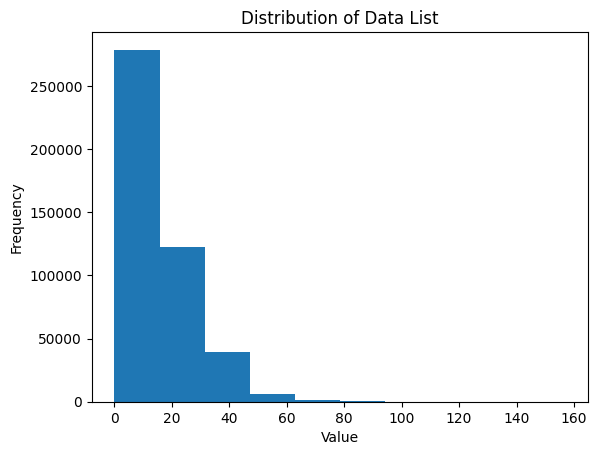

In [12]:
plt.hist(wordcount, bins=10) 
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data List')
plt.show()

In [13]:
# Return words in each line list are present in the dictionary
def words_in_dictionary(row):
    words_in_row = set(row)
    words_in_dictionary = words_in_row.intersection(lm_dict['Word'])
    return words_in_dictionary


word_dict = df['processed_articles'].apply(words_in_dictionary)
print(word_dict)

0         {growth, output, return, market, earnings, sup...
1         {option, growth, quarter, takeover, dividend, ...
2         {monopolistic, utility, output, market, earnin...
3         {parent, news, learning, smith, david, stock, ...
4         {trust, growth, service, future, dividend, goo...
                                ...                        
448390    {demand, growth, surplus, exchange, future, ra...
448391    {inflation, euro, policy, market, economy, deb...
448392    {standard, demand, regulation, bankruptcy, ser...
448393    {loan, standard, yield, asset, income, prospec...
448394    {option, growth, average, model, data, country...
Name: processed_articles, Length: 448395, dtype: object


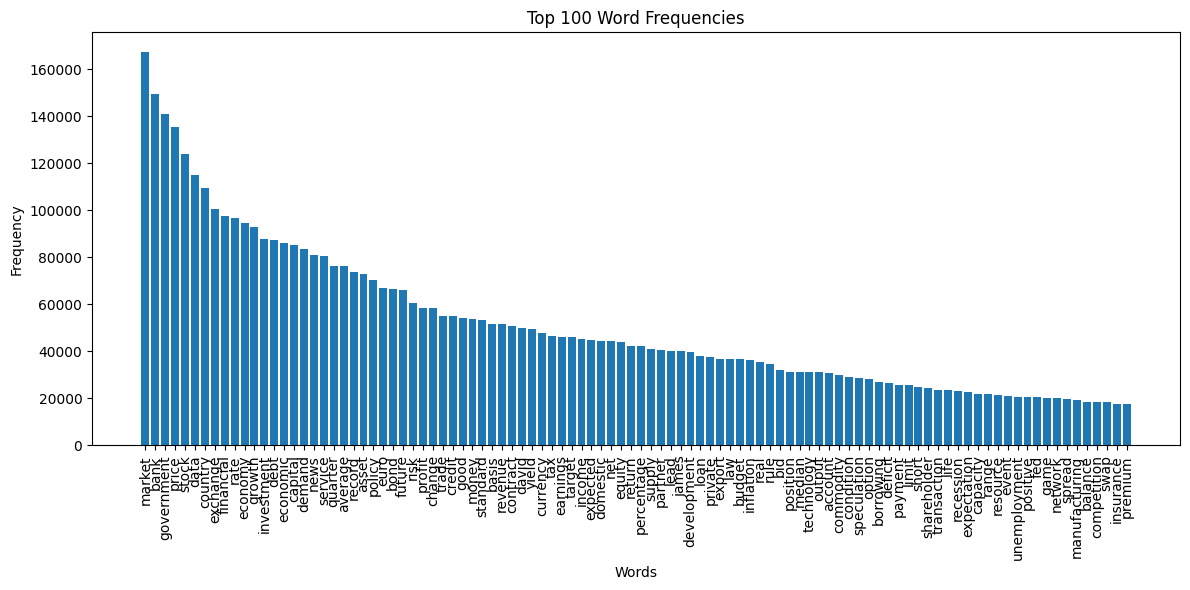

In [17]:
all_words = [word for words_set in word_dict for word in words_set]

# Calculate words frequency
word_counts = Counter(all_words)

# Select the most common words and their frequencies of occurrence
top_words = word_counts.most_common(100) 

# Visualize word frequencies as a bar chart
words, frequencies = zip(*top_words)
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 100 Word Frequencies')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
word_counts_dict = dict(word_counts)
df_wc = pd.DataFrame(list(word_counts_dict.items()), columns=['Word', 'Frequency'])
display(df_wc)

Word  Frequency
0           growth      92969
1           output      31177
2           return      42396
3           market     167310
4         earnings      46233
..             ...        ...
683        autarky          4
684       queueing          2
685            ecu          2
686        customs          4
687  capitalsaving          1

[688 rows x 2 columns]

In [19]:
description = df_wc.describe()
display(description)

Frequency
count     688.000000
mean     9571.488372
std     21479.838089
min         1.000000
25%       108.000000
50%       847.500000
75%      7181.000000
max    167310.000000

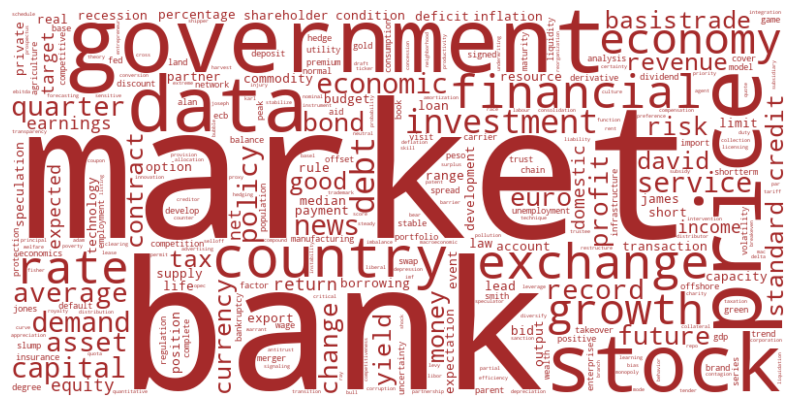

In [20]:
# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=300, background_color='white', color_func=lambda *args, **kwargs: "brown").generate_from_frequencies(word_counts_dict)

# Display the word cloud image
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()


In [25]:
#Forming a new dictionary based on financial words from the articles
financial_dictionary = list(word_counts_dict.keys())

In [19]:
# Save dictionaries with json format
file_path = './dictionaries/financial_dictionary.json'

with open(file_path, 'w') as json_file:
    json.dump(financial_dictionary, json_file, indent=4)

TF-IDF

In [26]:
df['processed_articles'] = df['processed_articles'].apply(lambda x: ' '.join(x))

In [27]:
#  Create TfidfVectorizer object, use daily term frequency instead of total corpus articles
def tfidf_per_day(docs):
    tfidf_vectorizer = TfidfVectorizer(vocabulary=financial_dictionary, smooth_idf=True)
    tfidf_data = tfidf_vectorizer.fit_transform(docs)
    # Save as DataFrame
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=financial_dictionary)
    return tfidf_df

# Group by date, calculate the number of articles appearing each day
grouped = df.groupby('times')['processed_articles'].apply(lambda x: ' '.join(x))
term_frequency_per_day = tfidf_per_day(grouped)


In [28]:
display(term_frequency_per_day)

growth    output    return    market  earnings    supply    demand  \
0     0.077667  0.589644  0.081344  0.069070  0.161024  0.081742  0.308852   
1     0.131021  0.000000  0.000000  0.233037  0.543280  0.000000  0.000000   
2     0.000000  0.061170  0.000000  0.100315  0.058466  0.118719  0.000000   
3     0.105023  0.000000  0.000000  0.233495  0.054435  0.331598  0.261021   
4     0.000000  0.000000  0.000000  0.066654  0.116543  0.039441  0.037256   
...        ...       ...       ...       ...       ...       ...       ...   
1939  0.103270  0.018667  0.051376  0.283937  0.036576  0.039852  0.098388   
1940  0.068181  0.012324  0.023803  0.136426  0.017669  0.077738  0.101673   
1941  0.071649  0.032378  0.093801  0.175225  0.018568  0.043988  0.065294   
1942  0.104336  0.025486  0.062021  0.303440  0.040925  0.040561  0.098119   
1943  0.162934  0.050489  0.065008  0.303599  0.024129  0.097990  0.092561   

       quarter     short    stable  ...  skillbiased  bancor  cannibalise  \
0     0.231516  0.086403  0.091877  ...          0.0     0.0          0.0   
1     0.260371  0.000000  0.000000  ...          0.0     0.0          0.0   
2     0.000000  0.000000  0.200157  ...          0.0     0.0          0.0   
3     0.052176  0.000000  0.000000  ...          0.0     0.0          0.0   
4     0.186180  0.000000  0.000000  ...          0.0     0.0          0.0   
...        ...       ...       ...  ...          ...     ...          ...   
1939  0.074393  0.074675  0.008144  ...          0.0     0.0          0.0   
1940  0.079037  0.069528  0.000000  ...          0.0     0.0          0.0   
1941  0.044495  0.046496  0.007063  ...          0.0     0.0          0.0   
1942  0.063510  0.072152  0.007784  ...          0.0     0.0          0.0   
1943  0.038546  0.112208  0.000000  ...          0.0     0.0          0.0   

      monopsony  ctd  autarky  queueing  ecu  customs  capitalsaving  
0           0.0  0.0      0.0       0.0  0.0      0.0            0.0  
1           0.0  0.0      0.0       0.0  0.0      0.0            0.0  
2           0.0  0.0      0.0       0.0  0.0      0.0            0.0  
3           0.0  0.0      0.0       0.0  0.0      0.0            0.0  
4           0.0  0.0      0.0       0.0  0.0      0.0            0.0  
...         ...  ...      ...       ...  ...      ...            ...  
1939        0.0  0.0      0.0       0.0  0.0      0.0            0.0  
1940        0.0  0.0      0.0       0.0  0.0      0.0            0.0  
1941        0.0  0.0      0.0       0.0  0.0      0.0            0.0  
1942        0.0  0.0      0.0       0.0  0.0      0.0            0.0  
1943        0.0  0.0      0.0       0.0  0.0      0.0            0.0  

[1944 rows x 688 columns]

In [206]:
#Add times to TF-IDF
times_df = df.groupby('times')['times'].first().reset_index(drop=True)
result_df = pd.concat([term_frequency_per_day, times_df], axis=1)

In [207]:
#  Convert timestamps to quarterly time
def convert_to_quarter(timestamp):
    date = datetime.strptime(timestamp, "%Y-%m-%d")
    quarter_year = date.year
    #Find the starting date of the quarter corresponding to the given month
    if(date.month >= 1 and date.month < 4 ):
        quarter_start =  4 
    elif(date.month >= 4 and date.month < 7 ):
        quarter_start =  7 
    elif(date.month >= 7 and date.month < 10 ):
        quarter_start =  10 
    else:
        quarter_year = date.year + 1
        quarter_start =  1 
    quarter_date = datetime(quarter_year, quarter_start, 1)
    return quarter_date.strftime("%Y-%m-%d")  

result_df['times_quarter'] = result_df['times'].apply(convert_to_quarter)

In [208]:
#  Convert timestamps to monthly time
def convert_to_month(timestamp):
    date = datetime.strptime(timestamp, "%Y-%m-%d")
    month_date = datetime(date.year, date.month, 1)
    return month_date.strftime("%Y-%m-%d")  

result_df['times_month'] = result_df['times'].apply(convert_to_month)

In [209]:
display(result_df)

growth    output    return    market  earnings    supply    demand  \
0     0.077667  0.589644  0.081344  0.069070  0.161024  0.081742  0.308852   
1     0.131021  0.000000  0.000000  0.233037  0.543280  0.000000  0.000000   
2     0.000000  0.061170  0.000000  0.100315  0.058466  0.118719  0.000000   
3     0.105023  0.000000  0.000000  0.233495  0.054435  0.331598  0.261021   
4     0.000000  0.000000  0.000000  0.066654  0.116543  0.039441  0.037256   
...        ...       ...       ...       ...       ...       ...       ...   
1939  0.103270  0.018667  0.051376  0.283937  0.036576  0.039852  0.098388   
1940  0.068181  0.012324  0.023803  0.136426  0.017669  0.077738  0.101673   
1941  0.071649  0.032378  0.093801  0.175225  0.018568  0.043988  0.065294   
1942  0.104336  0.025486  0.062021  0.303440  0.040925  0.040561  0.098119   
1943  0.162934  0.050489  0.065008  0.303599  0.024129  0.097990  0.092561   

       quarter     short    stable  ...  monopsony  ctd  autarky  queueing  \
0     0.231516  0.086403  0.091877  ...        0.0  0.0      0.0       0.0   
1     0.260371  0.000000  0.000000  ...        0.0  0.0      0.0       0.0   
2     0.000000  0.000000  0.200157  ...        0.0  0.0      0.0       0.0   
3     0.052176  0.000000  0.000000  ...        0.0  0.0      0.0       0.0   
4     0.186180  0.000000  0.000000  ...        0.0  0.0      0.0       0.0   
...        ...       ...       ...  ...        ...  ...      ...       ...   
1939  0.074393  0.074675  0.008144  ...        0.0  0.0      0.0       0.0   
1940  0.079037  0.069528  0.000000  ...        0.0  0.0      0.0       0.0   
1941  0.044495  0.046496  0.007063  ...        0.0  0.0      0.0       0.0   
1942  0.063510  0.072152  0.007784  ...        0.0  0.0      0.0       0.0   
1943  0.038546  0.112208  0.000000  ...        0.0  0.0      0.0       0.0   

      ecu  customs  capitalsaving       times  times_quarter  times_month  
0     0.0      0.0            0.0  2006-10-20     2007-01-01   2006-10-01  
1     0.0      0.0            0.0  2006-10-21     2007-01-01   2006-10-01  
2     0.0      0.0            0.0  2006-10-23     2007-01-01   2006-10-01  
3     0.0      0.0            0.0  2006-10-24     2007-01-01   2006-10-01  
4     0.0      0.0            0.0  2006-10-25     2007-01-01   2006-10-01  
...   ...      ...            ...         ...            ...          ...  
1939  0.0      0.0            0.0  2013-11-22     2014-01-01   2013-11-01  
1940  0.0      0.0            0.0  2013-11-23     2014-01-01   2013-11-01  
1941  0.0      0.0            0.0  2013-11-24     2014-01-01   2013-11-01  
1942  0.0      0.0            0.0  2013-11-25     2014-01-01   2013-11-01  
1943  0.0      0.0            0.0  2013-11-26     2014-01-01   2013-11-01  

[1944 rows x 691 columns]

In [210]:
def concatenate_vectors(group):
    vectors_to_concatenate = group.iloc[:, :-3].values 
    concatenated_matrix = np.vstack(vectors_to_concatenate) 
    return concatenated_matrix

#  Group by 'times_quarter' and apply the concatenation function
grouped_matrices_quarter = result_df.groupby('times_quarter').apply(concatenate_vectors)
#  Group by 'times_month' and apply the concatenation function
grouped_matrices_month = result_df.groupby('times_month').apply(concatenate_vectors)

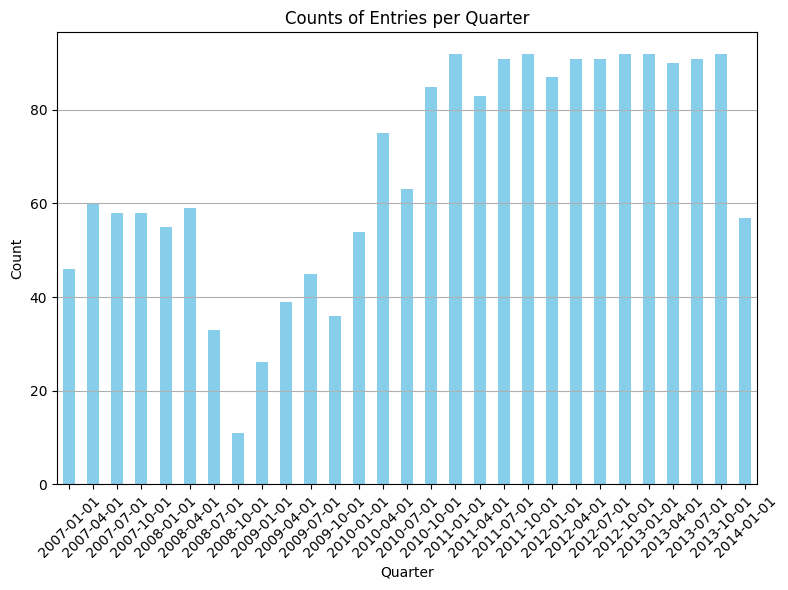

In [211]:
quarter_sizes = result_df.groupby('times_quarter').size()

# Plotting quarter_sizes distribution
plt.figure(figsize=(8, 6))
quarter_sizes.plot(kind='bar', color='skyblue')
plt.title('Counts of Entries per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y')  
plt.tight_layout()
plt.show()

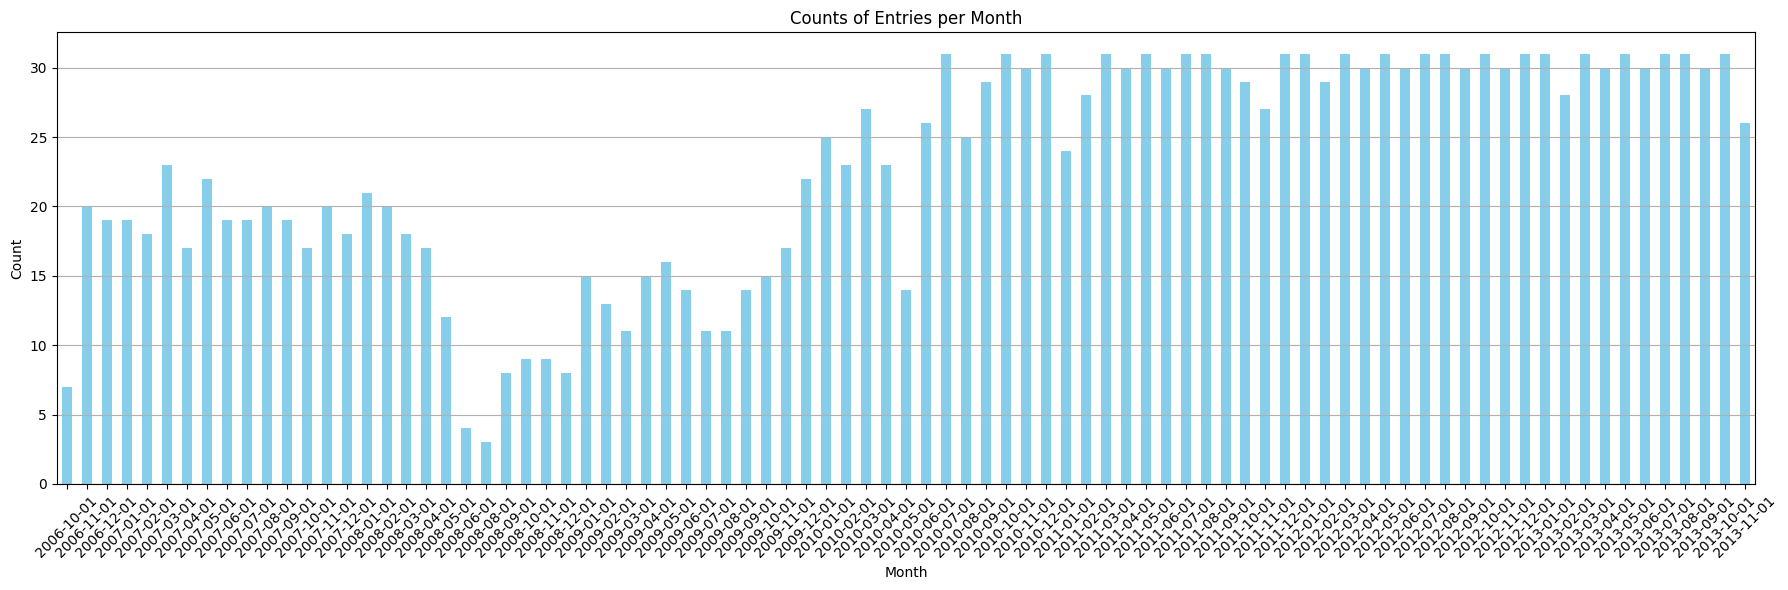

In [212]:
month_size = result_df.groupby('times_month').size()

# Plotting quarter_sizes distribution
plt.figure(figsize=(18, 6))
month_size.plot(kind='bar', color='skyblue')
plt.title('Counts of Entries per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y')  
plt.tight_layout()
plt.show()

In [213]:
# Create an LSA (Latent Semantic Analysis) model
lsa_model_quarter = TruncatedSVD(n_components= 10)
lsa_model_month = TruncatedSVD(n_components= 3)

#Quarter matrices
V_matrices_quarter = []
for matrix in grouped_matrices_quarter:
    # Perform LSA Singular Value Decomposition on matrices for each group
    lsa_model_quarter.fit(matrix)
    V_matrices_quarter.append(lsa_model_quarter.components_)
    
#Month matrices
V_matrices_month = []
for matrix in grouped_matrices_month:
    # Perform LSA Singular Value Decomposition on matrices for each group
    lsa_model_month.fit(matrix)
    V_matrices_month.append(lsa_model_month.components_)

In [218]:
#Fill in missing values
new_matrix = np.zeros((3, 688))
V_matrices_month.insert(21, new_matrix)

In [219]:
# Preprocess quarterly LSA matrices for machine learning
reshaped_data = np.vstack([arr.reshape(1, -1) for arr in V_matrices_quarter])
print(reshaped_data.shape)

# Preprocess monthly LSA matrices for machine learning
reshaped_data_month = np.vstack([arr.reshape(1, -1) for arr in V_matrices_month])
print(reshaped_data_month.shape)

(29, 6880)
(86, 2064)


### Predictive indicators

Quarterly indicators

- GDP

In [38]:
gdp = pd.read_csv('./Predictive indicators/Processed_GDP.csv')
gdp = gdp.drop('Unnamed: 0', axis=1)
display(gdp[['observation_date', 'CAGR2']])

observation_date     CAGR2
0         1961-01-01  0.600648
1         1961-04-01  0.627824
2         1961-07-01  0.659084
3         1961-10-01  0.691630
4         1962-01-01  0.312175
..               ...       ...
243       2021-10-01  0.038485
244       2022-01-01  0.037769
245       2022-04-01  0.037745
246       2022-07-01  0.037855
247       2022-10-01  0.037961

[248 rows x 2 columns]

In [39]:
predictive_gdp = gdp[(gdp['observation_date'] >= '2007-01-01') & (gdp['observation_date'] <= '2014-01-01')]
display(predictive_gdp)

observation_date      GDPC1  InflationCoeff  inflation_GDP  \
184       2007-01-01  16611.690        6.915666    2402.037602   
185       2007-04-01  16713.314        6.915666    2416.732354   
186       2007-07-01  16809.587        6.915666    2430.653356   
187       2007-10-01  16915.191        6.915666    2445.923613   
188       2008-01-01  16843.003        7.112947    2367.935830   
189       2008-04-01  16943.291        7.112947    2382.035189   
190       2008-07-01  16854.295        7.112947    2369.523357   
191       2008-10-01  16485.350        7.112947    2317.653861   
192       2009-01-01  16298.262        7.386021    2206.636418   
193       2009-04-01  16269.145        7.386021    2202.694241   
194       2009-07-01  16326.281        7.386021    2210.429935   
195       2009-10-01  16502.754        7.386021    2234.322774   
196       2010-01-01  16582.710        7.359760    2253.159112   
197       2010-04-01  16743.162        7.359760    2274.960367   
198       2010-07-01  16872.266        7.359760    2292.502244   
199       2010-10-01  16960.864        7.359760    2304.540408   
200       2011-01-01  16920.632        7.480463    2261.976528   
201       2011-04-01  17035.114        7.480463    2277.280661   
202       2011-07-01  17031.313        7.480463    2276.772537   
203       2011-10-01  17222.583        7.480463    2302.341810   
204       2012-01-01  17367.010        7.716609    2250.601125   
205       2012-04-01  17444.525        7.716609    2260.646340   
206       2012-07-01  17469.650        7.716609    2263.902303   
207       2012-10-01  17489.852        7.716609    2266.520292   
208       2013-01-01  17662.400        7.876292    2242.476488   
209       2013-04-01  17709.671        7.876292    2248.478170   
210       2013-07-01  17860.450        7.876292    2267.621569   
211       2013-10-01  18016.147        7.876292    2287.389373   
212       2014-01-01  17953.974        7.991667    2246.586945   

     GDP Growth Rate      CAGR     CAGR2  
184        -0.028337 -0.008081  0.044128  
185         0.006118 -0.007952  0.044263  
186         0.005760 -0.007831  0.044391  
187         0.006282 -0.007699  0.044530  
188        -0.031885 -0.008209  0.043490  
189         0.005954 -0.008086  0.043619  
190        -0.005253 -0.008195  0.043504  
191        -0.021890 -0.008652  0.043023  
192        -0.047901 -0.009469  0.041884  
193        -0.001787 -0.009505  0.041846  
194         0.003512 -0.009434  0.041921  
195         0.010809 -0.009217  0.042149  
196         0.008430 -0.008867  0.041390  
197         0.009676 -0.008676  0.041590  
198         0.007711 -0.008524  0.041750  
199         0.005251 -0.008420  0.041859  
200        -0.018470 -0.008618  0.040974  
201         0.006766 -0.008487  0.041111  
202        -0.000223 -0.008491  0.041107  
203         0.011230 -0.008274  0.041335  
204        -0.022473 -0.008549  0.040691  
205         0.004463 -0.008464  0.040780  
206         0.001440 -0.008437  0.040809  
207         0.001156 -0.008415  0.040832  
208        -0.010608 -0.008456  0.040239  
209         0.002676 -0.008406  0.040292  
210         0.008514 -0.008247  0.040458  
211         0.008717 -0.008085  0.040628  
212        -0.017838 -0.008267  0.039795

Monthly indicators

In [42]:
MI_df = pd.read_csv('./Predictive indicators/monthly_merged_label.csv')
MI_df = MI_df[(MI_df['observation_date'] >= '2006-10-01') & (MI_df['observation_date'] < '2013-12-01')]

In [45]:
MI_df

observation_date    PAYEMS    CE16OV    INDPRO      CMRMT   PCEC96  \
1053       2006-10-01  136848.0  145314.0   99.1253  1214355.0      NaN   
1054       2006-11-01  137069.0  145534.0   99.0969  1215059.0      NaN   
1055       2006-12-01  137253.0  145970.0  100.1122  1234494.0      NaN   
1056       2007-01-01  137476.0  146028.0   99.7571  1226965.0  11181.0   
1057       2007-02-01  137554.0  146057.0  100.7275  1234327.0  11178.2   
...               ...       ...       ...       ...        ...      ...   
1134       2013-07-01  136391.0  144264.0   98.9258  1244157.0  11872.3   
1135       2013-08-01  136635.0  144326.0   99.5059  1249320.0  11890.3   
1136       2013-09-01  136819.0  144418.0  100.0391  1253661.0  11926.1   
1137       2013-10-01  137039.0  143537.0   99.9203  1260475.0  11964.6   
1138       2013-11-01  137314.0  144479.0  100.1661  1275801.0  12013.7   

      W875RX1  
1053  11562.6  
1054  11624.9  
1055  11683.5  
1056  11666.7  
1057  11713.7  
...       ...  
1134  12155.0  
1135  12176.8  
1136  12235.2  
1137  12189.0  
1138  12228.0  

[86 rows x 7 columns]

- PAYEMS

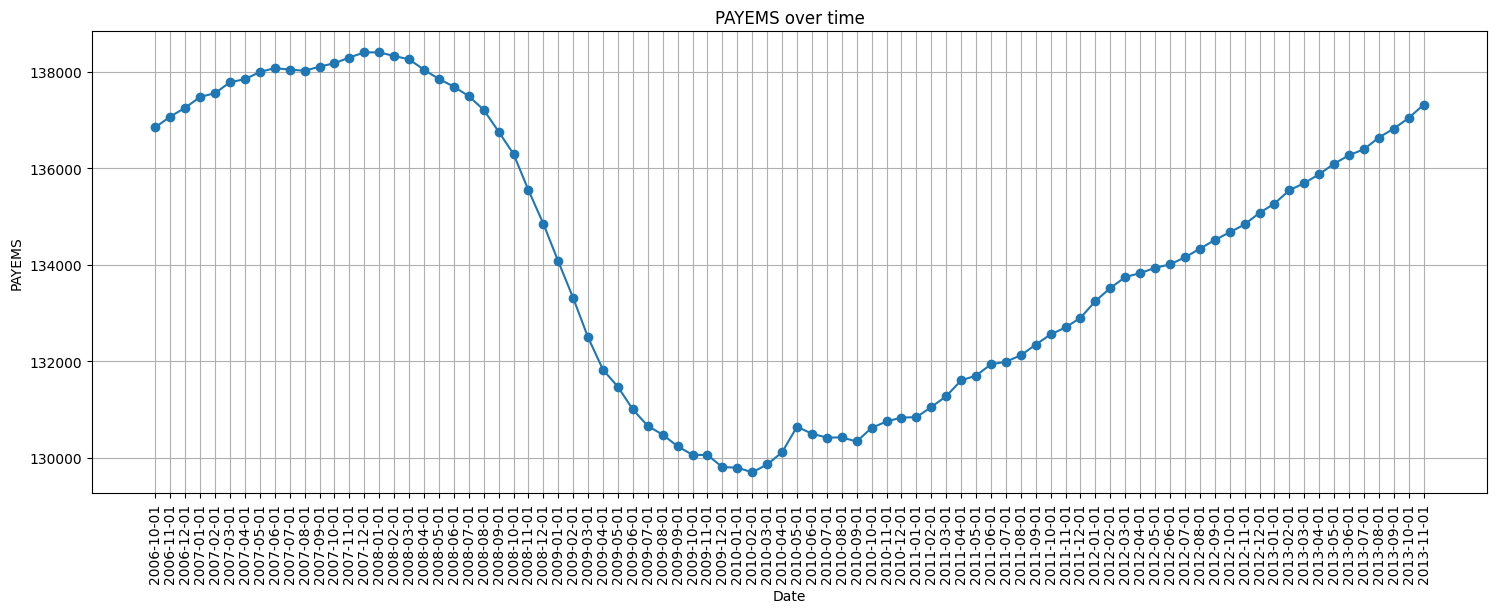

In [50]:
payems = MI_df['PAYEMS']
#Plotting
plt.figure(figsize=(18, 6))
plt.plot(MI_df['observation_date'], MI_df['PAYEMS'], marker='o', linestyle='-')
plt.title('PAYEMS over time')
plt.xticks(rotation=90)  
plt.xlabel('Date')
plt.ylabel('PAYEMS')
plt.grid(True)
plt.show()

- INDPRO

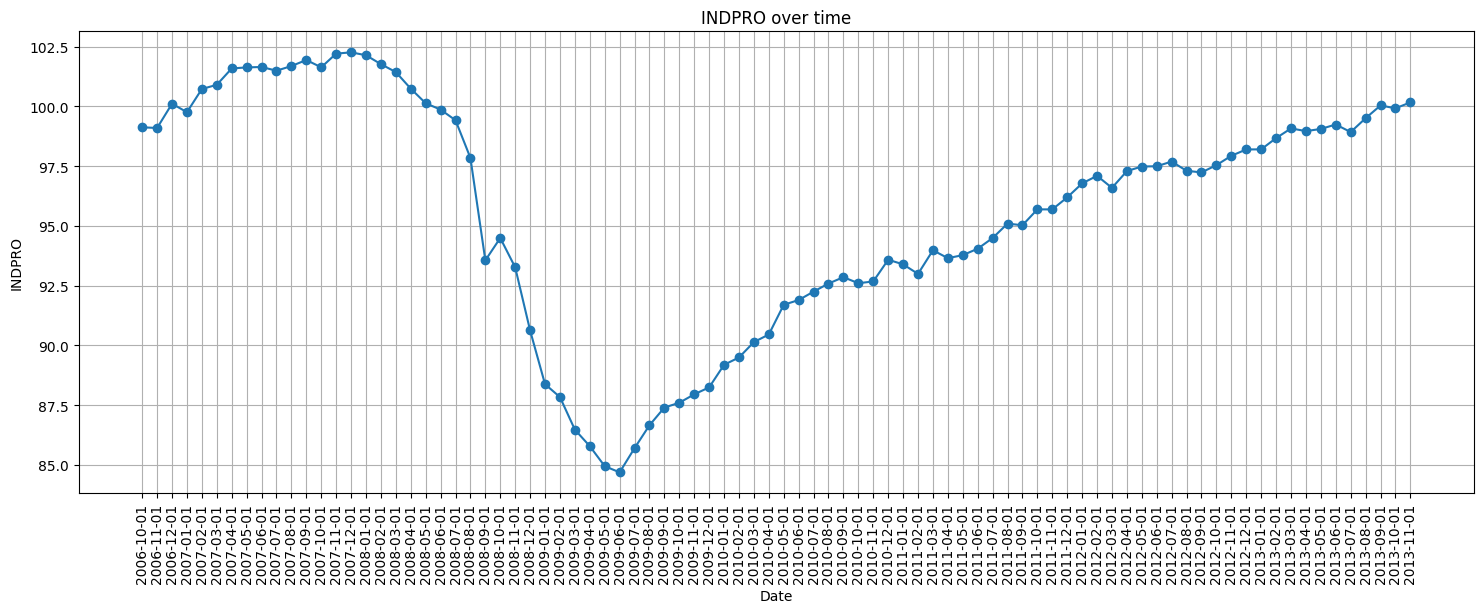

In [51]:
indpro = MI_df['INDPRO']
#Plotting
plt.figure(figsize=(18, 6))
plt.plot(MI_df['observation_date'], MI_df['INDPRO'], marker='o', linestyle='-')
plt.title('INDPRO over time')
plt.xticks(rotation=90)  
plt.xlabel('Date')
plt.ylabel('INDPRO')
plt.grid(True)
plt.show()

- CMRMT

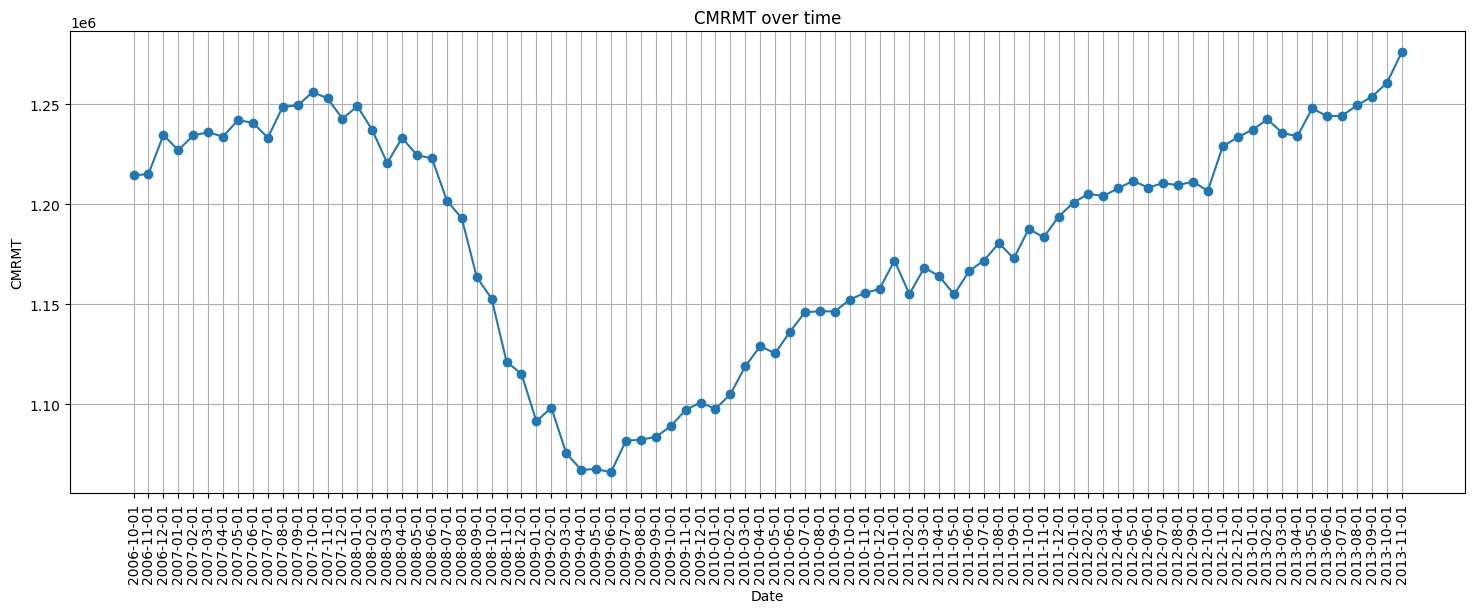

In [52]:
cmrmt = MI_df['CMRMT']
#Plotting
plt.figure(figsize=(18, 6))
plt.plot(MI_df['observation_date'], MI_df['CMRMT'], marker='o', linestyle='-')
plt.title('CMRMT over time')
plt.xticks(rotation=90)  
plt.xlabel('Date')
plt.ylabel('CMRMT')
plt.grid(True)
plt.show()

### Machine learning prediciton

Hyperparameter tuning

In [138]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [227]:
# GridSearch for hyperparameter tuning
def GridSearch(model, param_grid, X_train, y_train):
    # Perform Grid Search with TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=4)
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='r2')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Scores:", best_score)
    
    return

In [277]:
X = reshaped_data_month
y = cmrmt.values # Convert y to a NumPy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [279]:
# Define SVR model
svr = SVR()

# Define hyperparameters to search
svr_param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 'auto']
}

GridSearch(svr, svr_param_grid, X_train, y_train)

Best Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Best Scores: -0.4105313618124291


In [280]:
# Define DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)

# Define hyperparameters to search
tree_reg_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['friedman_mse', 'poisson', 'squared_error', 'absolute_error']
}

GridSearch(tree_reg, tree_reg_param_grid, X_train, y_train)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_split': 2}
Best Scores: -0.35454063010154124


In [281]:
# Define RandomForestRegressor model
RFG = RandomForestRegressor(random_state=42)

# Define hyperparameters to search
RFG_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

GridSearch(RFG, RFG_param_grid, X_train, y_train)


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Scores: 0.3170253560294334


In [282]:
# Define GradientBoostingRegressor model
gbr = GradientBoostingRegressor(random_state=42)

# Define hyperparameters to search
gbr_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}
GridSearch(gbr, gbr_param_grid, X_train, y_train)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best Scores: 0.2469477288512469


In [289]:
# Define MLPRegressor model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, solver='lbfgs')

# Define hyperparameters to search
mlp_param_grid = {
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}
GridSearch(mlp, mlp_param_grid, X_train, y_train)

D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or sca

Best Parameters: {'activation': 'logistic', 'alpha': 0.0001, 'learning_rate': 'adaptive'}
Best Scores: -3.979303809619263


Model training and predicting

- GDP

In [258]:
#Changing different indicators here
X = reshaped_data
y = predictive_gdp['CAGR2'].values # Convert y to a NumPy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a list of models
models = [
    LinearRegression(),
    SVR(kernel='linear', C = 0.1, gamma = 0.1),
    DecisionTreeRegressor(criterion='poisson', max_depth=5, min_samples_split=2),
    RandomForestRegressor(n_estimators=50, random_state=42, max_depth = 5, min_samples_split = 2),
    GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=150),
    MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, solver='lbfgs', activation='relu', alpha=0.001, learning_rate='invscaling')
]

In [242]:
# Create an empty list to store results
results = []

for model in models:
    # Get model names
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Append results as a dictionary to the list
    results.append({
        'Model': model_name,
        'Training R^2': train_score,
        'Testing R^2': test_score,
        'Training MAE': train_mae,
        'Testing MAE': test_mae,
        'Training MSE': train_mse,
        'Testing MSE': test_mse,
        'Training MAPE': train_mape,
        'Testing MAPE': test_mape
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results in tabular form
display(results_df)

Model  Training R^2  Testing R^2  Training MAE  \
0           LinearRegression      1.000000    -0.015389  3.122502e-18   
1                        SVR     -0.003717    -0.466593  1.256156e-03   
2      DecisionTreeRegressor      0.999955     0.334825  3.056205e-06   
3      RandomForestRegressor      0.972800     0.660058  1.868576e-04   
4  GradientBoostingRegressor      1.000000     0.612284  9.911298e-09   
5               MLPRegressor      0.206703 -1492.571730  9.113212e-04   

   Testing MAE  Training MSE   Testing MSE  Training MAPE  Testing MAPE  
0     0.000977  3.611119e-35  1.157859e-06   7.253622e-15      2.356896  
1     0.001166  2.085060e-06  1.672372e-06   2.981353e+00      2.815247  
2     0.000686  9.340387e-11  7.585065e-07   7.295780e-03      1.643718  
3     0.000556  5.650449e-08  3.876399e-07   4.450929e-01      1.334379  
4     0.000518  2.131279e-16  4.421167e-07   2.354894e-05      1.234931  
5     0.034785  1.647947e-06  1.703136e-03   2.185885e+00     83.971301

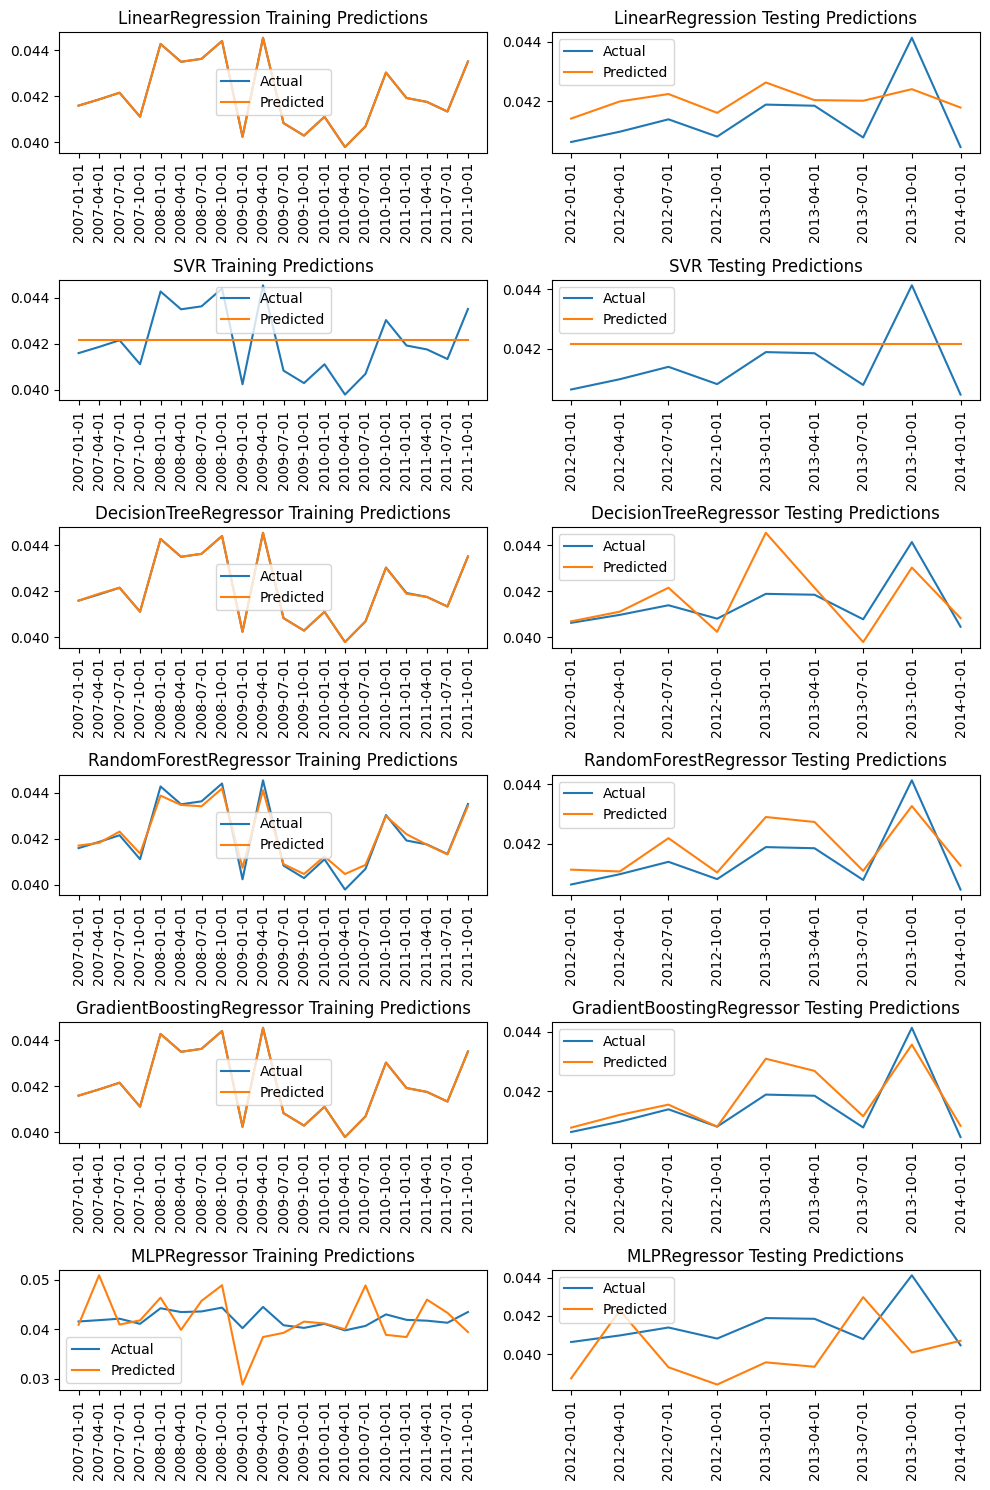

In [168]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 15))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # Get models predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Plotting training values and predicted values
    axes[i, 0].plot(predictive_gdp['observation_date'][:len(y_train)], y_train, label='Actual')
    axes[i, 0].plot(predictive_gdp['observation_date'][:len(y_train)], y_pred_train, label='Predicted')
    axes[i, 0].set_title(f"{model_name} Training Predictions")
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=90)
    
    # Plotting testing values and predicted values
    axes[i, 1].plot(predictive_gdp['observation_date'][len(y_train):], y_test, label='Actual')
    axes[i, 1].plot(predictive_gdp['observation_date'][len(y_train):], y_pred_test, label='Predicted')
    axes[i, 1].set_title(f"{model_name} Testing Predictions")
    axes[i, 1].legend()
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


- Rolling test

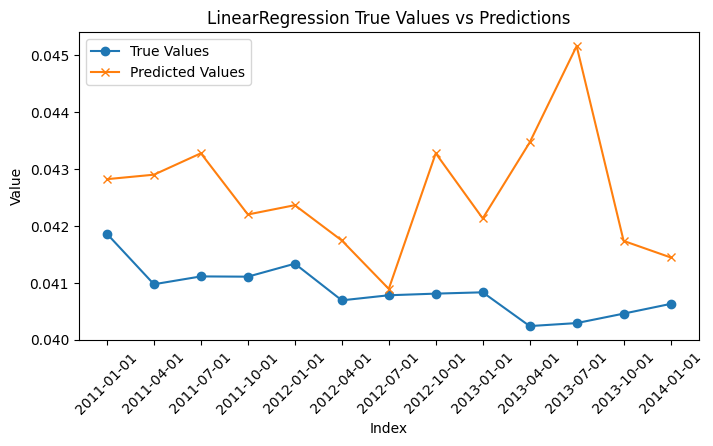

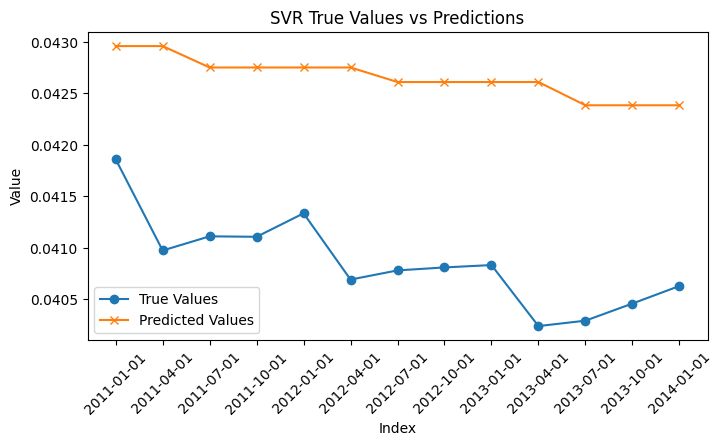

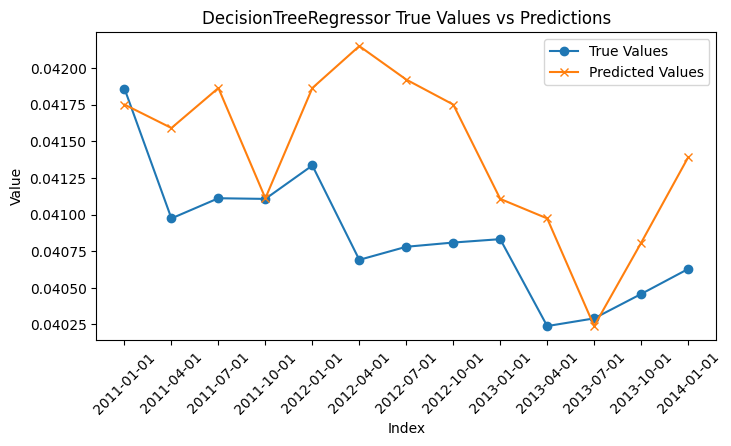

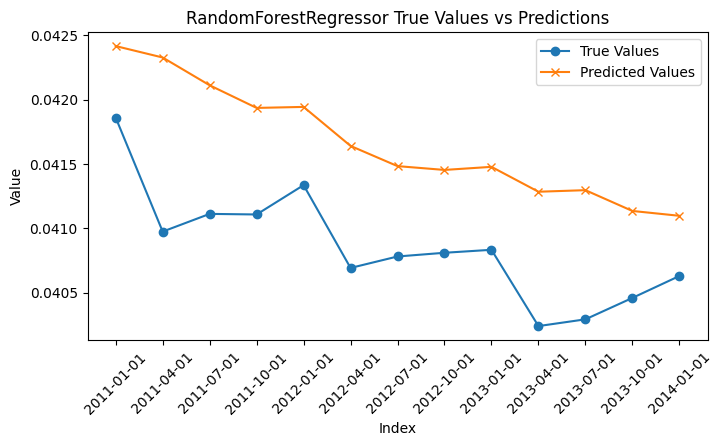

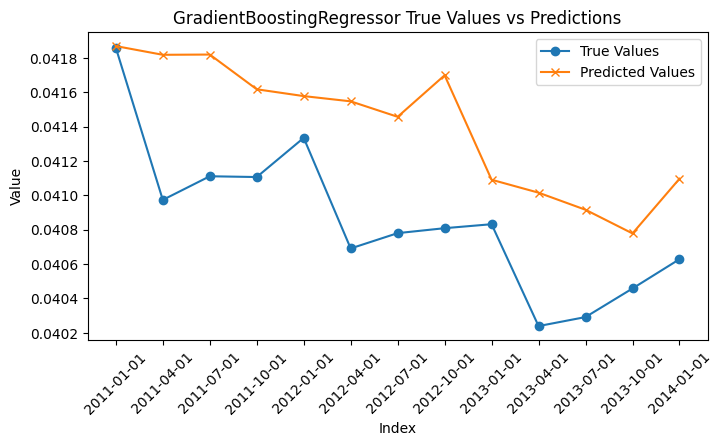

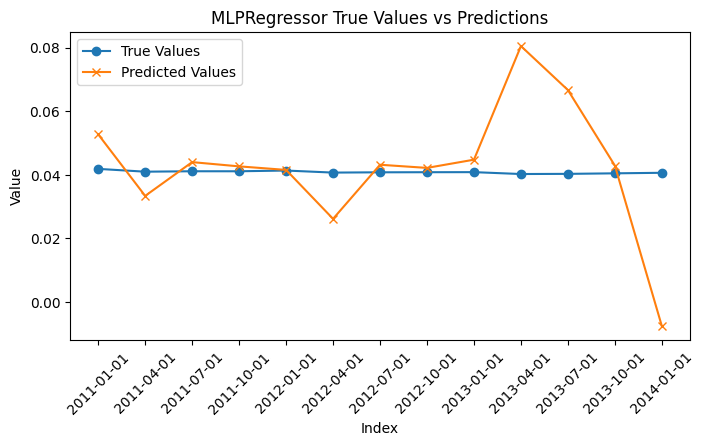

In [259]:
window_size = 15  # Size of the sliding window
step_size = 1  

n_samples = len(X)

for model in models:
    model_name = model.__class__.__name__
    model_predictions = []
    true_values = []

    for i in range(0, n_samples - window_size - 1, step_size):
        # Increase the length of the training set
        X_train = X[0:i+window_size]
        y_train = y[0:i+window_size]
        
        # Predicting one quarter after
        X_test = X[i+window_size:i+window_size+1]
        y_test = y[i+window_size]

        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        predicted_value = prediction[-1]
        model_predictions.append(predicted_value)
        true_values.append(y_test)

    # Plotting true values and predicted values for the current model
    plt.figure(figsize=(8, 4))
    plt.plot(predictive_gdp['observation_date'][window_size+1:],true_values, label='True Values', marker='o')
    plt.plot(predictive_gdp['observation_date'][window_size+1:],model_predictions, label='Predicted Values', marker='x')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} True Values vs Predictions')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


PAYEMS

In [260]:
X = reshaped_data_month
y = payems.values # Convert y to a NumPy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [261]:
# Define a list of models
models = [
    LinearRegression(),
    SVR(kernel='linear', C = 10, gamma = 0.1),
    DecisionTreeRegressor(criterion='absolute_error', max_depth=10, min_samples_split=5),
    RandomForestRegressor(n_estimators=50, random_state=42, max_depth = 10, min_samples_split = 2),
    GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=150),
    MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, solver='lbfgs', activation='relu', alpha=0.001, learning_rate='invscaling')
]

In [246]:
# Create an empty list to store results
results = []

for model in models:
    # Get model names
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Append results as a dictionary to the list
    results.append({
        'Model': model_name,
        'Training R^2': train_score,
        'Testing R^2': test_score,
        'Training MAE': train_mae,
        'Testing MAE': test_mae,
        'Training MSE': train_mse,
        'Testing MSE': test_mse,
        'Training MAPE': train_mape,
        'Testing MAPE': test_mape
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results in tabular form
display(results_df)


Model  Training R^2  Testing R^2  Training MAE  \
0           LinearRegression      1.000000     0.570942  5.991965e-12   
1                        SVR      0.021570    -0.048093  2.751628e+03   
2      DecisionTreeRegressor      0.993584    -0.351631  1.373235e+02   
3      RandomForestRegressor      0.947128     0.907658  5.597175e+02   
4  GradientBoostingRegressor      1.000000     0.805014  2.137864e-01   
5               MLPRegressor      1.000000     0.542262  1.269019e-04   

   Testing MAE  Training MSE   Testing MSE  Training MAPE  Testing MAPE  
0  1326.200604  1.370200e-22  2.395043e+06   4.526358e-15      0.984126  
1  2028.895453  9.177153e+06  5.850550e+06   2.055624e+00      1.498620  
2  1878.055556  6.018100e+04  7.544927e+06   1.026741e-01      1.383726  
3   577.683333  4.959146e+05  5.154620e+05   4.185429e-01      0.429548  
4   700.578200  6.587552e-02  1.088428e+06   1.589746e-04      0.519862  
5  1405.846071  3.055718e-08  2.555135e+06   9.488449e-08      1.042742

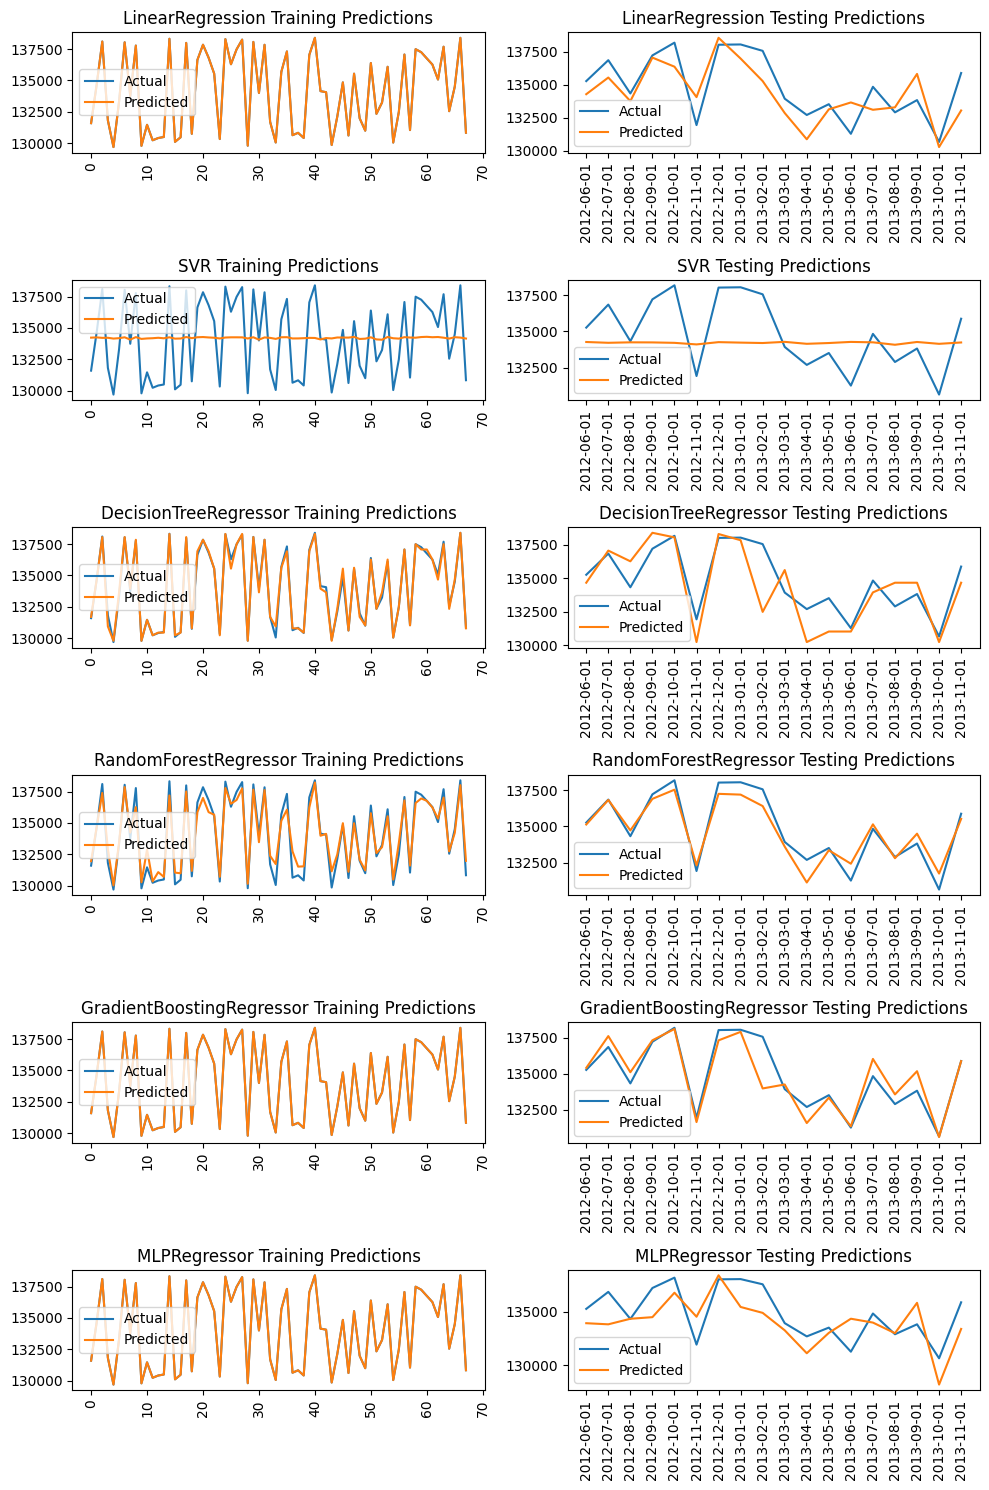

In [247]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 15))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # Get models predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Plotting training values and predicted values
    axes[i, 0].plot(y_train, label='Actual')
    axes[i, 0].plot(y_pred_train, label='Predicted')
    axes[i, 0].set_title(f"{model_name} Training Predictions")
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=90)
    
    # Plotting testing values and predicted values
    axes[i, 1].plot(MI_df['observation_date'][len(y_pred_train):], y_test, label='Actual')
    axes[i, 1].plot(MI_df['observation_date'][len(y_pred_train):], y_pred_test, label='Predicted')
    axes[i, 1].set_title(f"{model_name} Testing Predictions")
    axes[i, 1].legend()
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



- Rolling test

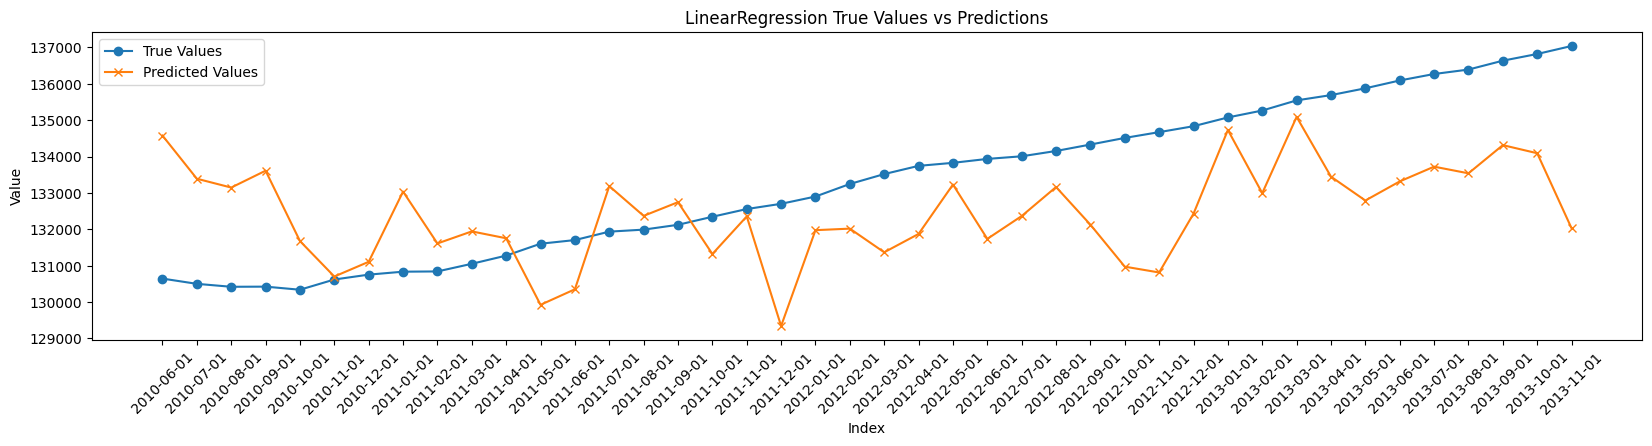

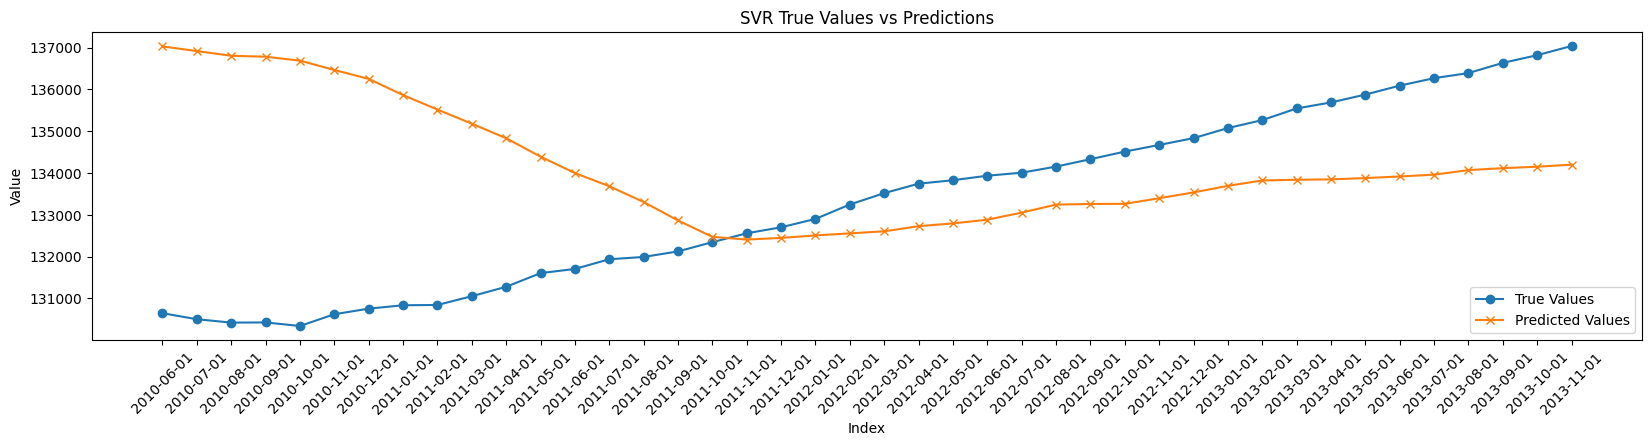

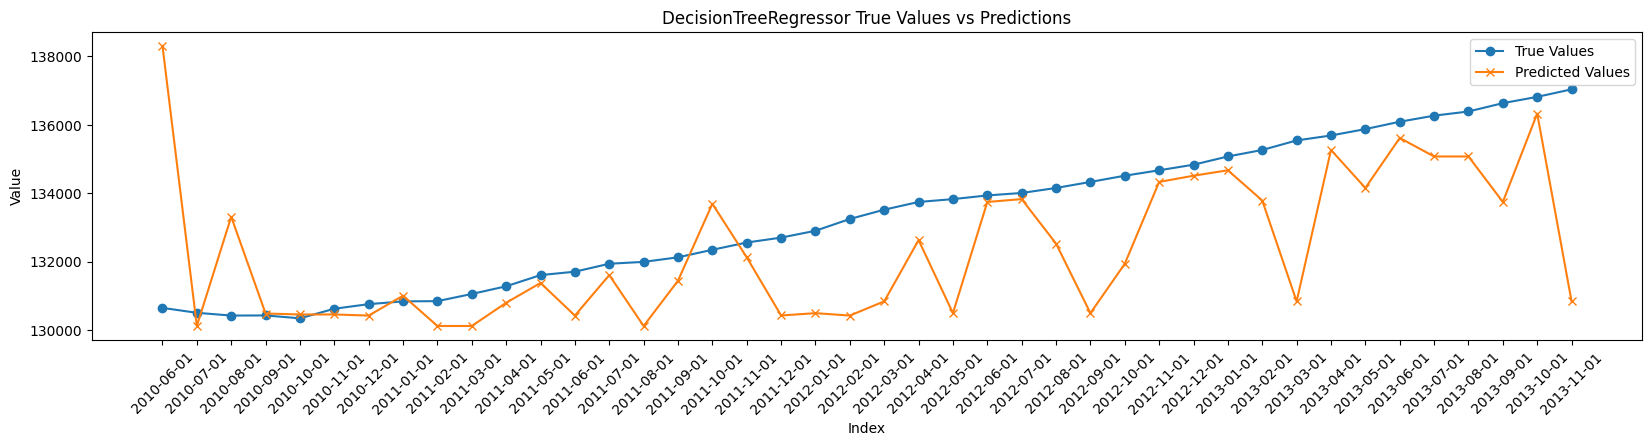

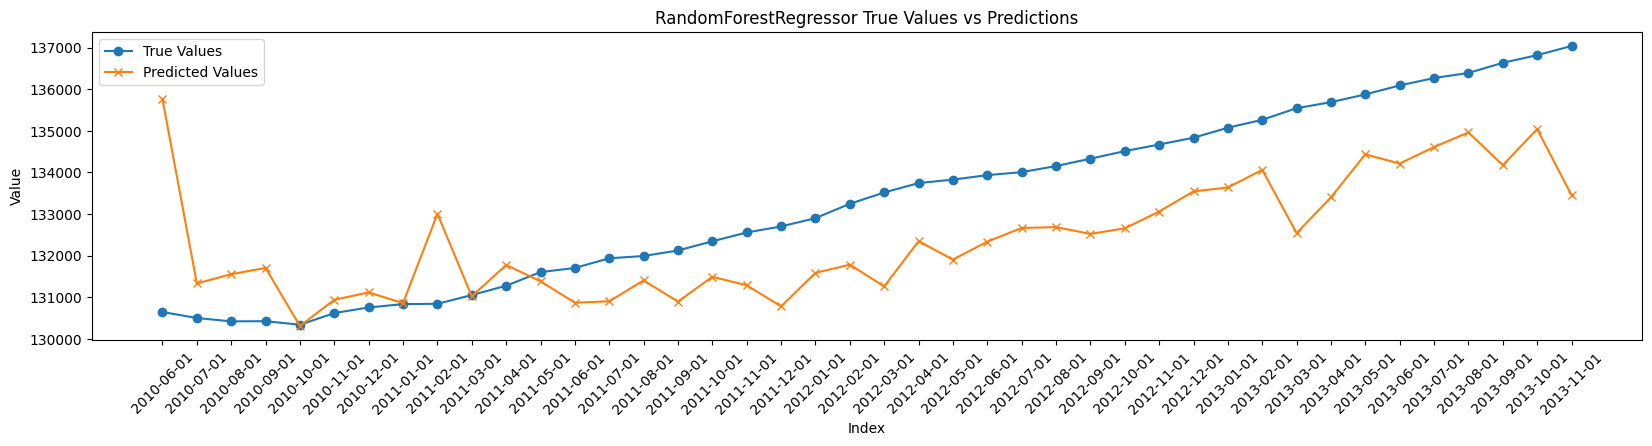

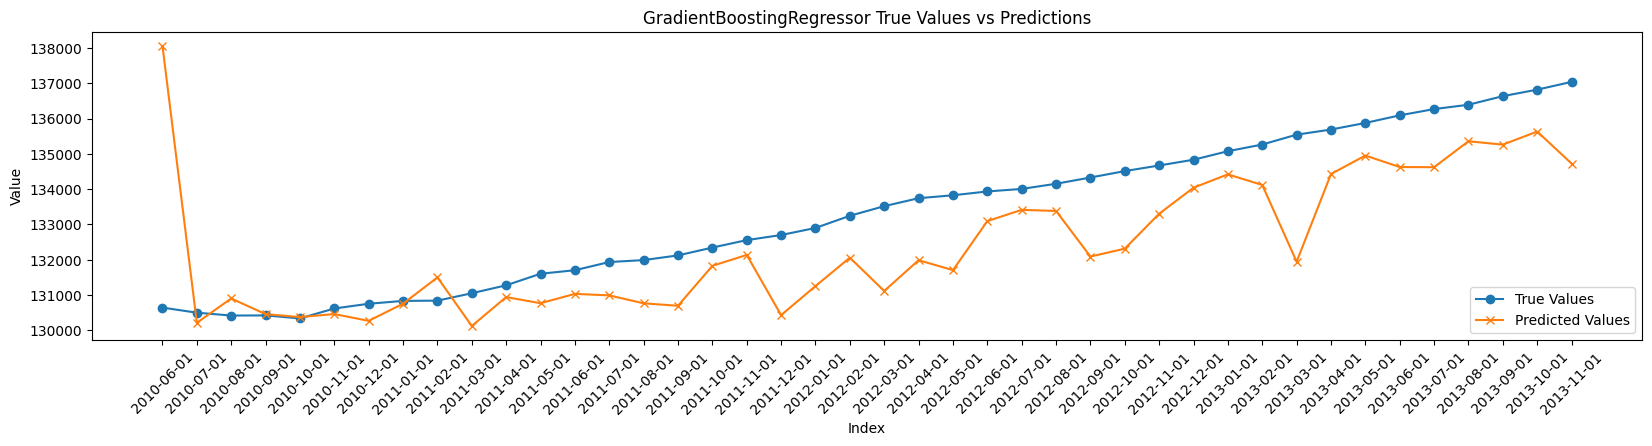

D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


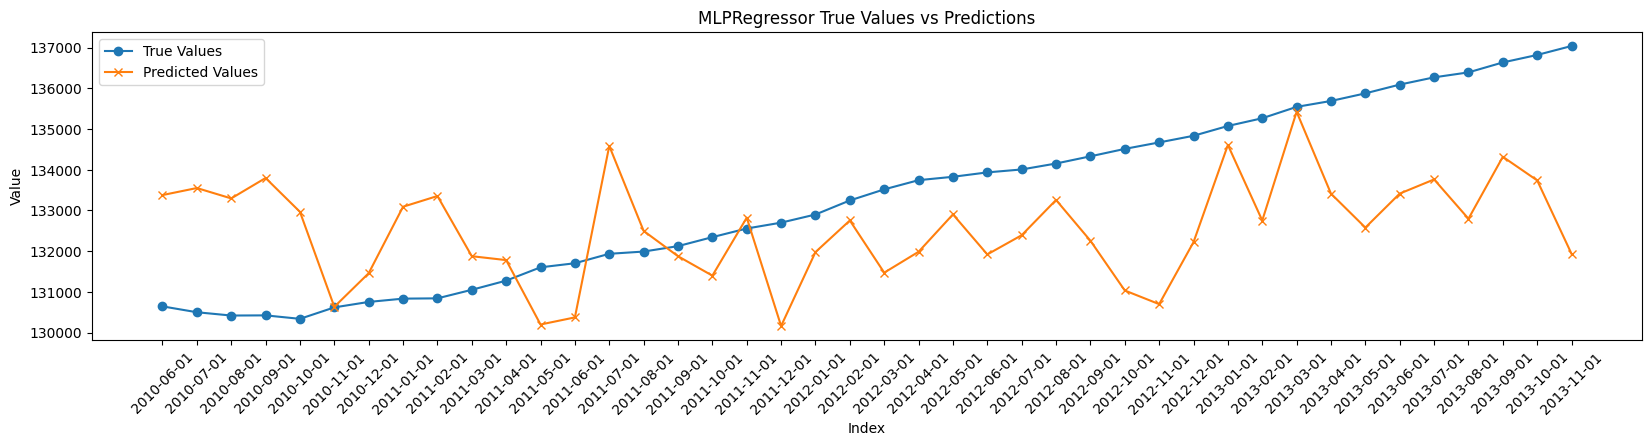

In [262]:
window_size = 43  # Size of the sliding window
step_size = 1  

n_samples = len(X)

for model in models:
    model_name = model.__class__.__name__
    model_predictions = []
    true_values = []

    for i in range(0, n_samples - window_size - 1, step_size):
        X_train = X[0:i+window_size]
        y_train = y[0:i+window_size]
        
        # Predicting one month after
        X_test = X[i+window_size:i+window_size+1]
        y_test = y[i+window_size]

        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        predicted_value = prediction[-1]
        model_predictions.append(predicted_value)
        true_values.append(y_test)

    # Plotting true values and predicted values for the current model
    plt.figure(figsize=(20, 4))
    plt.plot(MI_df['observation_date'][window_size+1:],true_values, label='True Values', marker='o')
    plt.plot(MI_df['observation_date'][window_size+1:],model_predictions, label='Predicted Values', marker='x')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} True Values vs Predictions')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


- INDPRO

In [272]:
X = reshaped_data_month
y = indpro.values # Convert y to a NumPy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [273]:
# Define a list of models
models = [
    LinearRegression(),
    SVR(kernel='linear', C = 10, gamma = 0.1),
    DecisionTreeRegressor(criterion='absolute_error', max_depth=10, min_samples_split=2),
    RandomForestRegressor(n_estimators=100, random_state=42, max_depth = 10, min_samples_split = 2),
    GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=150),
    MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, solver='lbfgs', activation='relu', alpha=0.001, learning_rate='invscaling')
]

In [270]:
# Create an empty list to store results
results = []

for model in models:
    # Get model names
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Append results as a dictionary to the list
    results.append({
        'Model': model_name,
        'Training R^2': train_score,
        'Testing R^2': test_score,
        'Training MAE': train_mae,
        'Testing MAE': test_mae,
        'Training MSE': train_mse,
        'Testing MSE': test_mse,
        'Training MAPE': train_mape,
        'Testing MAPE': test_mape
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results in tabular form
display(results_df)


Model  Training R^2  Testing R^2  Training MAE  \
0           LinearRegression      1.000000     0.374963  1.483780e-14   
1                        SVR      0.997984     0.465009  1.257024e-01   
2      DecisionTreeRegressor      1.000000     0.281264  0.000000e+00   
3      RandomForestRegressor      0.934758     0.678801  1.103054e+00   
4  GradientBoostingRegressor      1.000000     0.774777  5.177117e-04   
5               MLPRegressor      1.000000     0.505196  3.583835e-04   

   Testing MAE  Training MSE  Testing MSE  Training MAPE  Testing MAPE  
0     2.304579  4.068666e-28     7.958469   1.577325e-14      2.404364  
1     2.188690  5.279583e-02     6.811929   1.312279e-01      2.274847  
2     2.068789  0.000000e+00     9.151522   0.000000e+00      2.132510  
3     1.615157  1.708375e+00     4.089761   1.171608e+00      1.686782  
4     1.235657  3.973941e-07     2.867726   5.427012e-04      1.275663  
5     2.091215  2.402310e-07     6.300245   3.783228e-04      2.168924

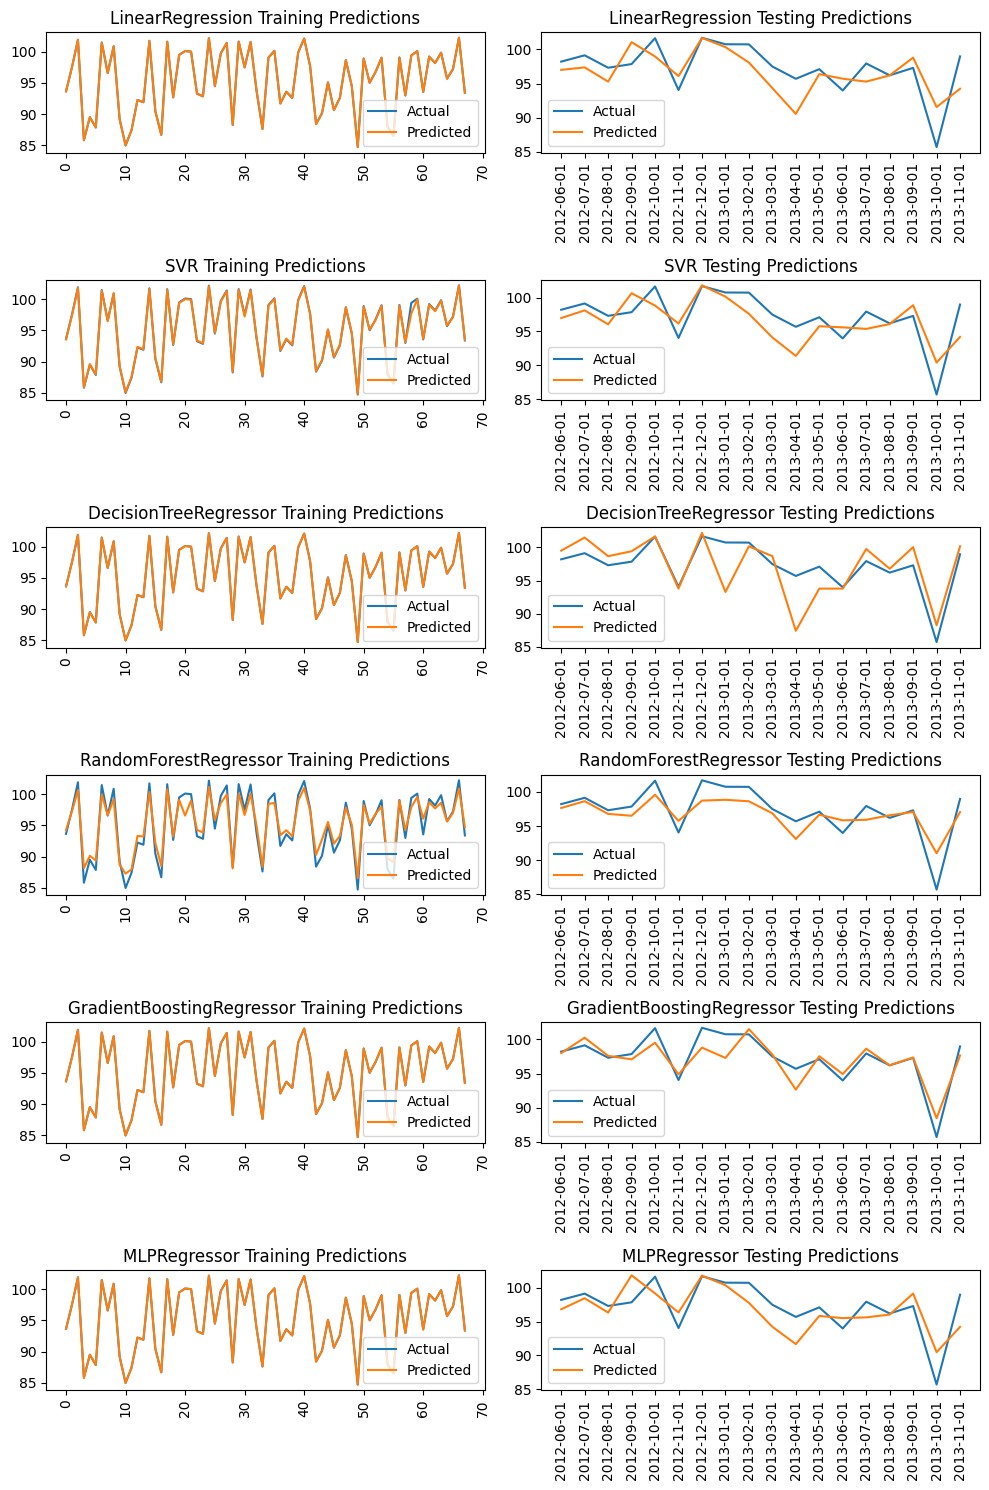

In [274]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 15))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # Get models predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Plotting training values and predicted values
    axes[i, 0].plot(y_train, label='Actual')
    axes[i, 0].plot(y_pred_train, label='Predicted')
    axes[i, 0].set_title(f"{model_name} Training Predictions")
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=90)
    
    # Plotting testing values and predicted values
    axes[i, 1].plot(MI_df['observation_date'][len(y_pred_train):], y_test, label='Actual')
    axes[i, 1].plot(MI_df['observation_date'][len(y_pred_train):], y_pred_test, label='Predicted')
    axes[i, 1].set_title(f"{model_name} Testing Predictions")
    axes[i, 1].legend()
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


- Rolling test

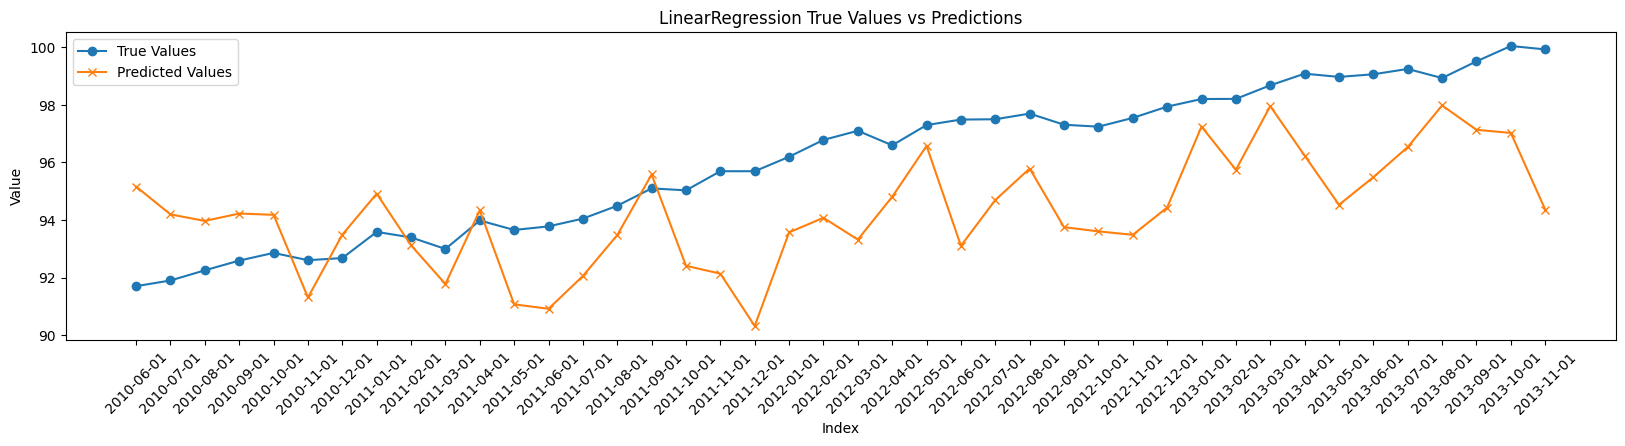

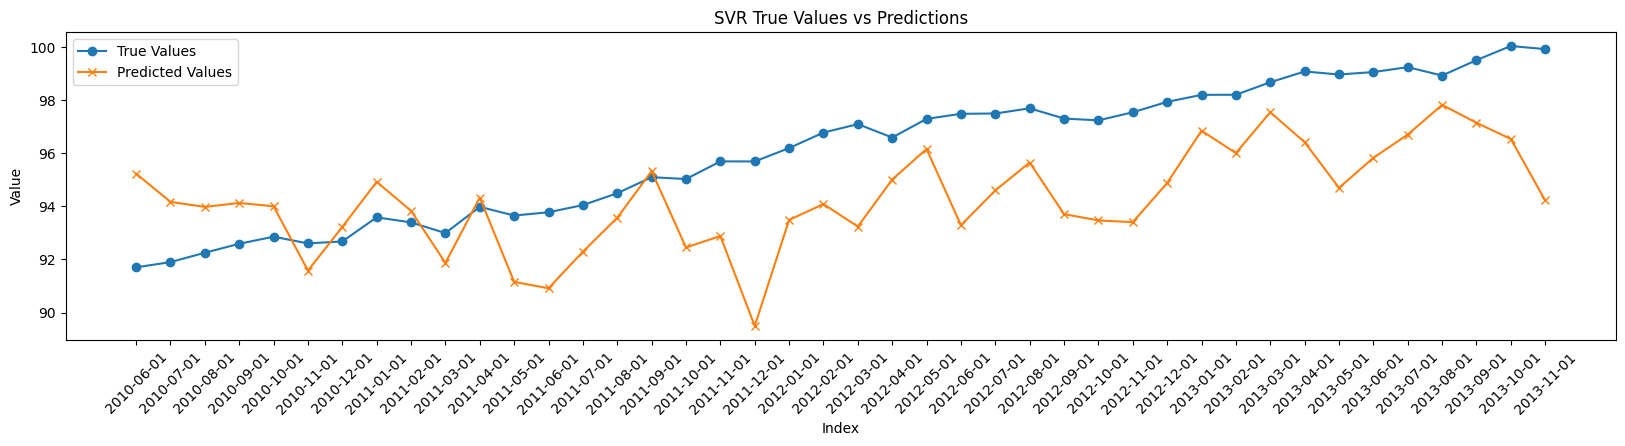

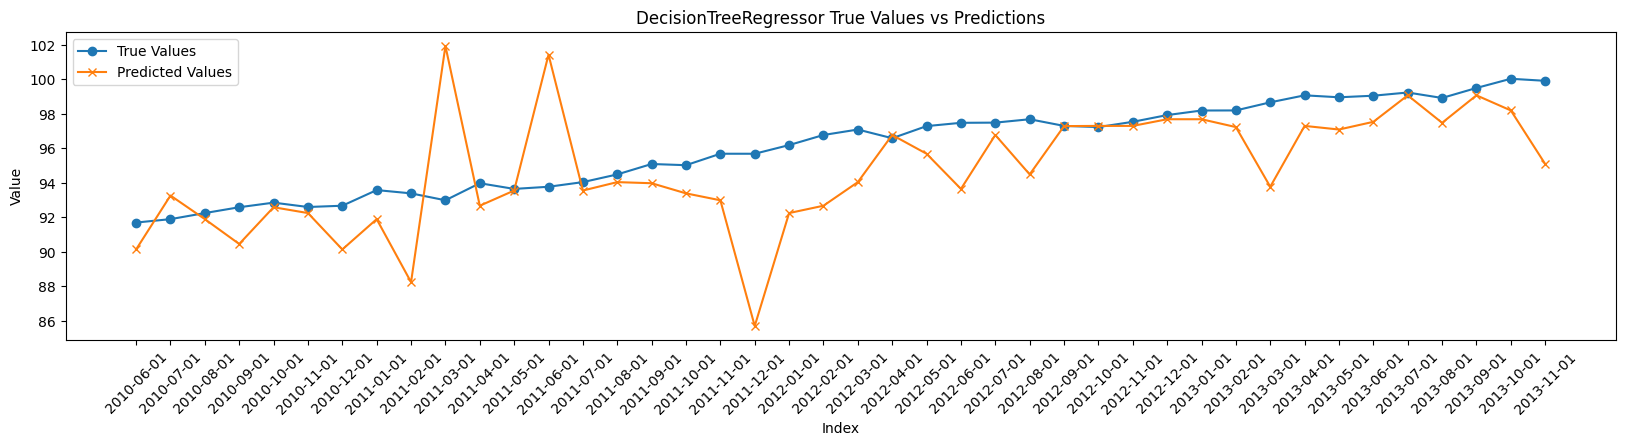

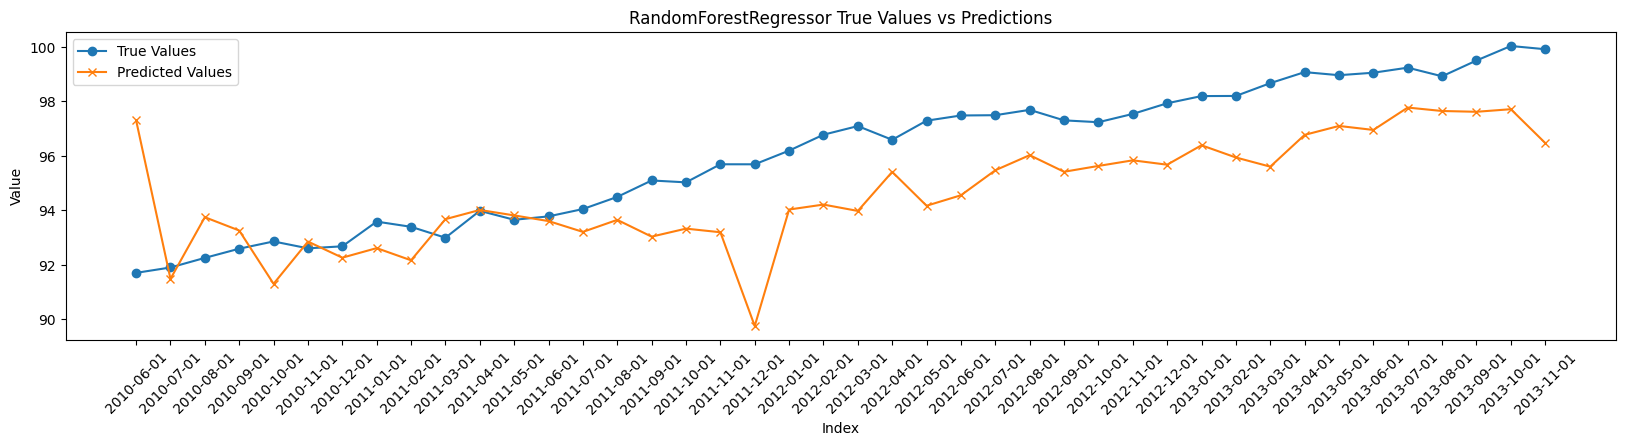

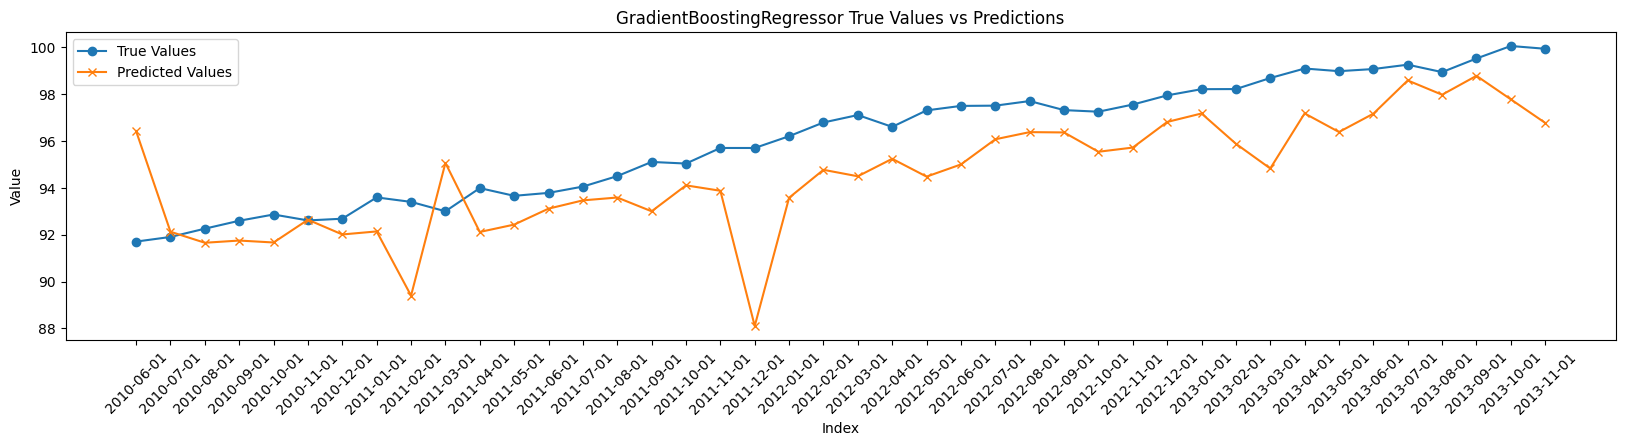

D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

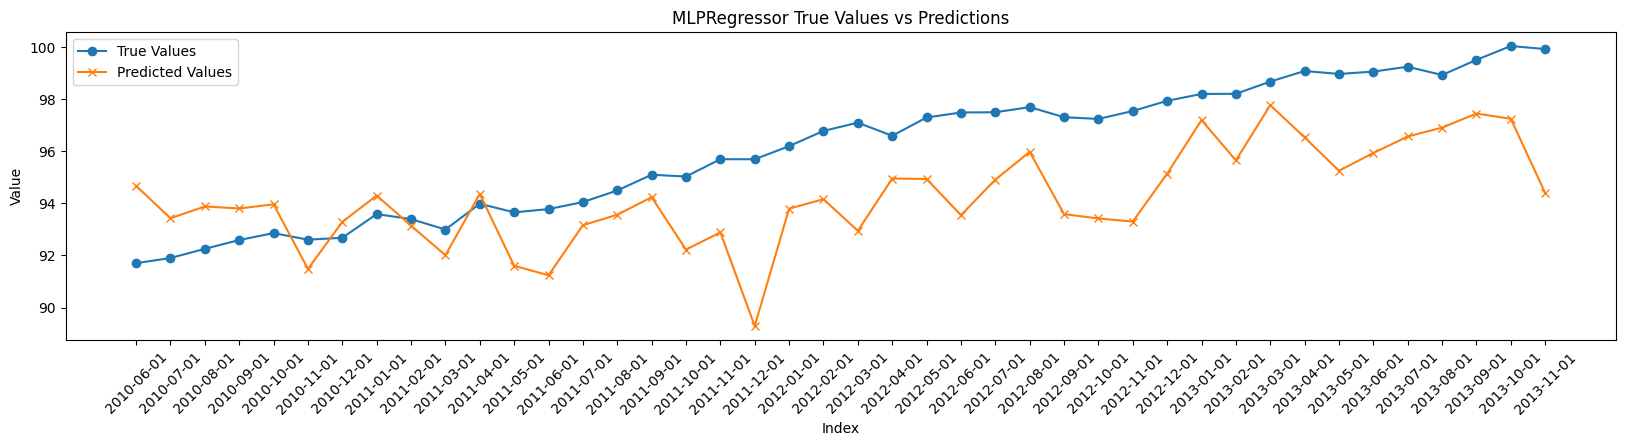

In [275]:
window_size = 43  # Size of the sliding window
step_size = 1  

n_samples = len(X)

for model in models:
    model_name = model.__class__.__name__
    model_predictions = []
    true_values = []

    for i in range(0, n_samples - window_size - 1, step_size):
        X_train = X[0:i+window_size]
        y_train = y[0:i+window_size]
        
        # Predicting one month after
        X_test = X[i+window_size:i+window_size+1]
        y_test = y[i+window_size]

        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        predicted_value = prediction[-1]
        model_predictions.append(predicted_value)
        true_values.append(y_test)

    # Plotting true values and predicted values for the current model
    plt.figure(figsize=(20, 4))
    plt.plot(MI_df['observation_date'][window_size+1:],true_values, label='True Values', marker='o')
    plt.plot(MI_df['observation_date'][window_size+1:],model_predictions, label='Predicted Values', marker='x')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} True Values vs Predictions')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


- CMRMT

In [283]:
X = reshaped_data_month
y = cmrmt.values # Convert y to a NumPy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [285]:
# Define a list of models
models = [
    LinearRegression(),
    SVR(kernel='poly', C = 0.1, gamma = 'auto'),
    DecisionTreeRegressor(criterion='absolute_error', max_depth=15, min_samples_split=2),
    RandomForestRegressor(n_estimators=100, random_state=42, max_depth = 10, min_samples_split = 5),
    GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=150),
    MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, solver='lbfgs', activation='relu', alpha=0.001, learning_rate='invscaling')
]

In [286]:
# Create an empty list to store results
results = []

for model in models:
    # Get model names
    model_name = model.__class__.__name__
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Append results as a dictionary to the list
    results.append({
        'Model': model_name,
        'Training R^2': train_score,
        'Testing R^2': test_score,
        'Training MAE': train_mae,
        'Testing MAE': test_mae,
        'Training MSE': train_mse,
        'Testing MSE': test_mse,
        'Training MAPE': train_mape,
        'Testing MAPE': test_mape
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results)

# Display the results in tabular form
display(results_df)


Model  Training R^2  Testing R^2  Training MAE  \
0           LinearRegression      1.000000     0.334724  1.506551e-10   
1                        SVR     -0.008644    -0.312468  5.318500e+04   
2      DecisionTreeRegressor      1.000000    -0.620108  0.000000e+00   
3      RandomForestRegressor      0.930403     0.686457  1.300205e+04   
4  GradientBoostingRegressor      1.000000     0.653473  4.968788e+00   
5               MLPRegressor      1.000000     0.358603  2.854308e-04   

    Testing MAE  Training MSE   Testing MSE  Training MAPE  Testing MAPE  
0  27609.590658  4.304920e-20  1.015041e+09   1.298679e-14      2.300915  
1  36991.166667  3.657135e+09  2.002489e+09   4.582489e+00      3.076692  
2  37945.222222  0.000000e+00  2.471870e+09   0.000000e+00      3.137255  
3  17882.938455  2.523452e+08  4.783862e+08   1.114947e+00      1.494187  
4  16041.073534  3.454222e+01  5.287112e+08   4.227715e-04      1.317039  
5  27191.571347  1.835325e-07  9.786070e+08   2.395125e-08      2.262988

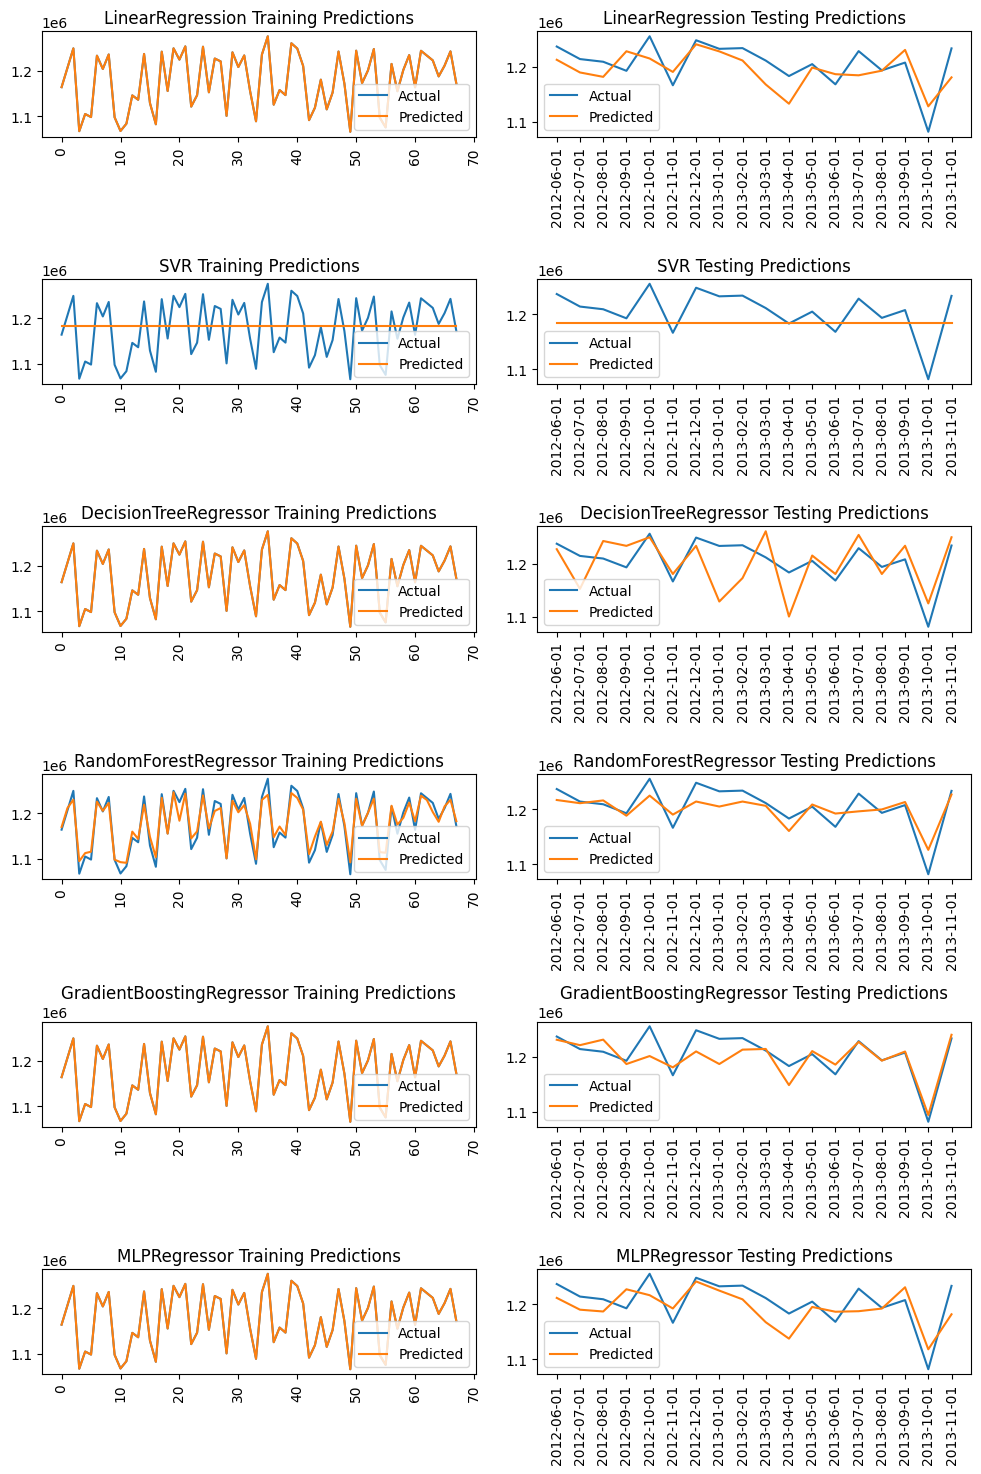

In [287]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 15))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    
    # Get models predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Plotting training values and predicted values
    axes[i, 0].plot(y_train, label='Actual')
    axes[i, 0].plot(y_pred_train, label='Predicted')
    axes[i, 0].set_title(f"{model_name} Training Predictions")
    axes[i, 0].legend()
    axes[i, 0].tick_params(axis='x', rotation=90)
    
    # Plotting testing values and predicted values
    axes[i, 1].plot(MI_df['observation_date'][len(y_pred_train):], y_test, label='Actual')
    axes[i, 1].plot(MI_df['observation_date'][len(y_pred_train):], y_pred_test, label='Predicted')
    axes[i, 1].set_title(f"{model_name} Testing Predictions")
    axes[i, 1].legend()
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


- Rolling test

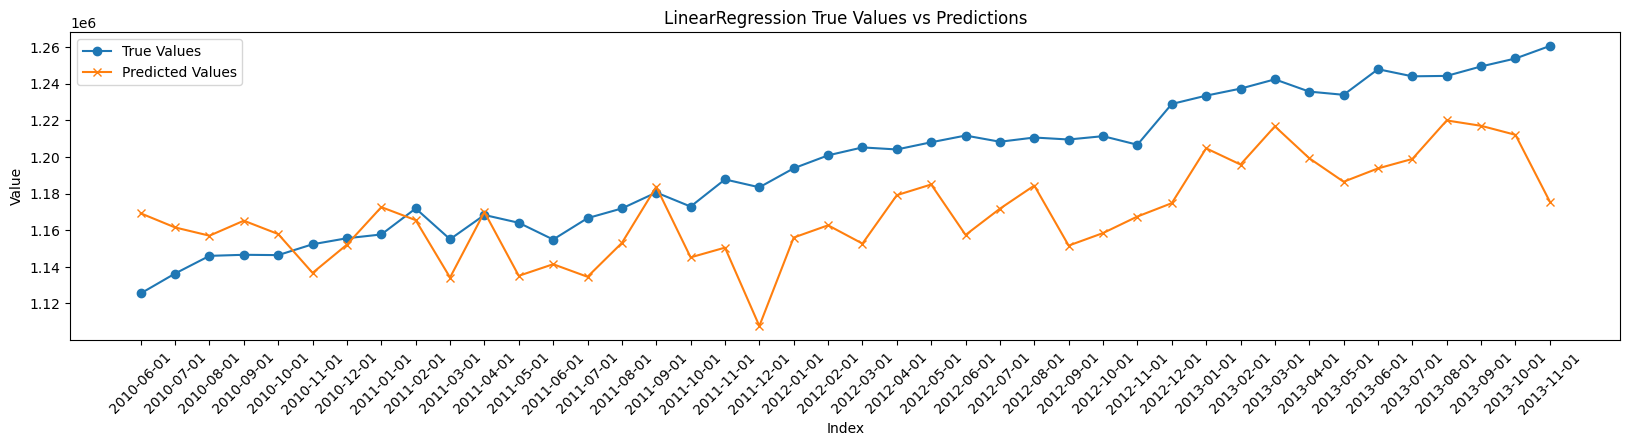

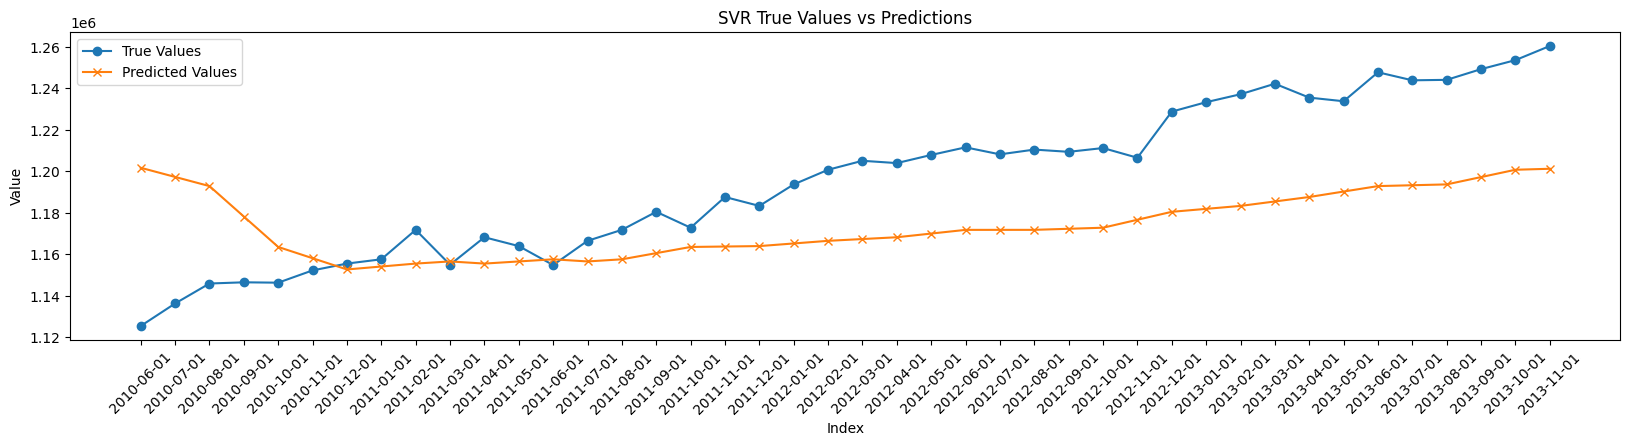

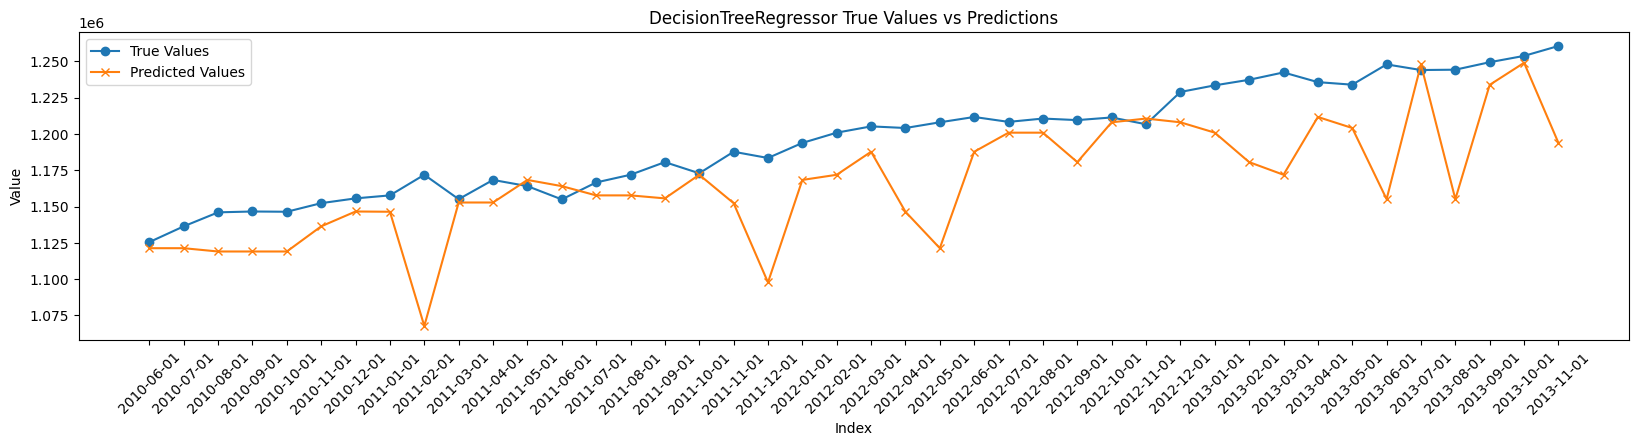

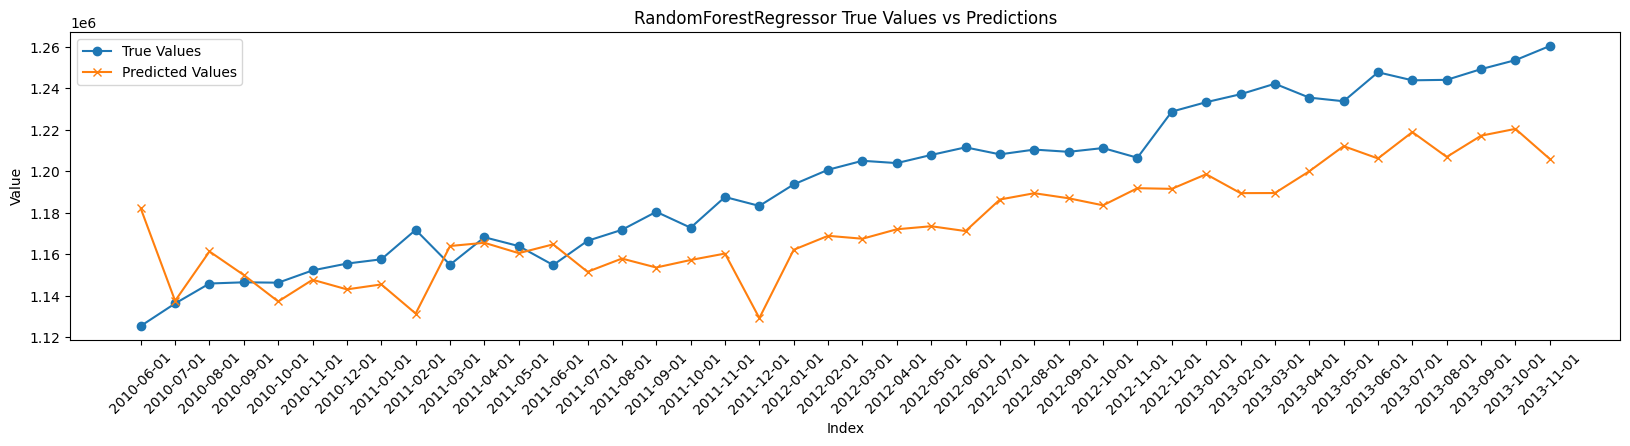

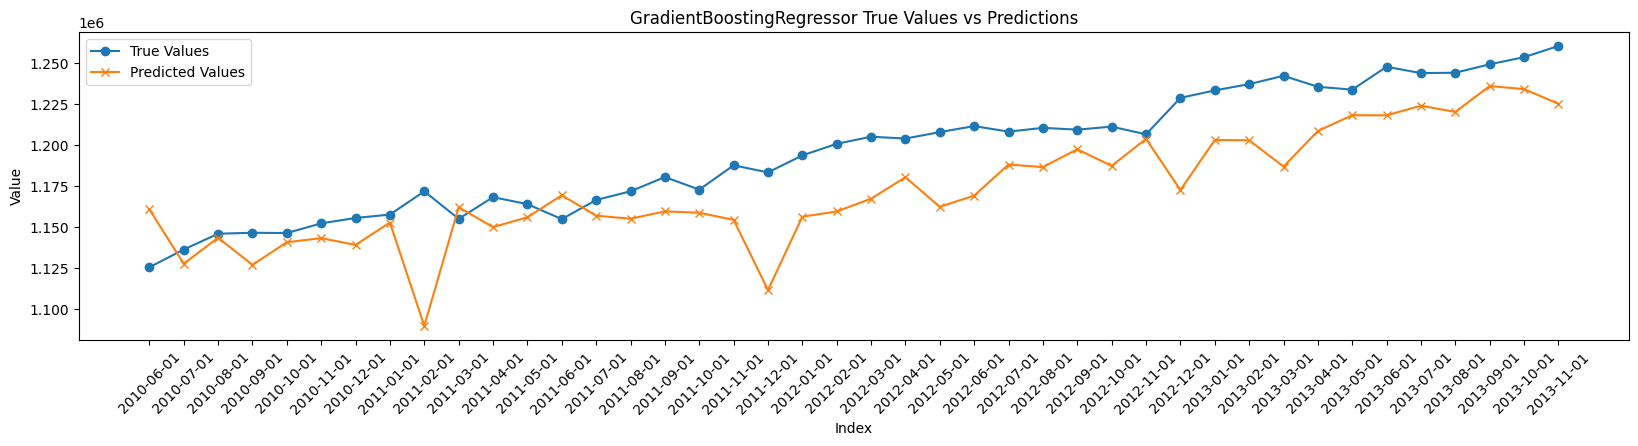

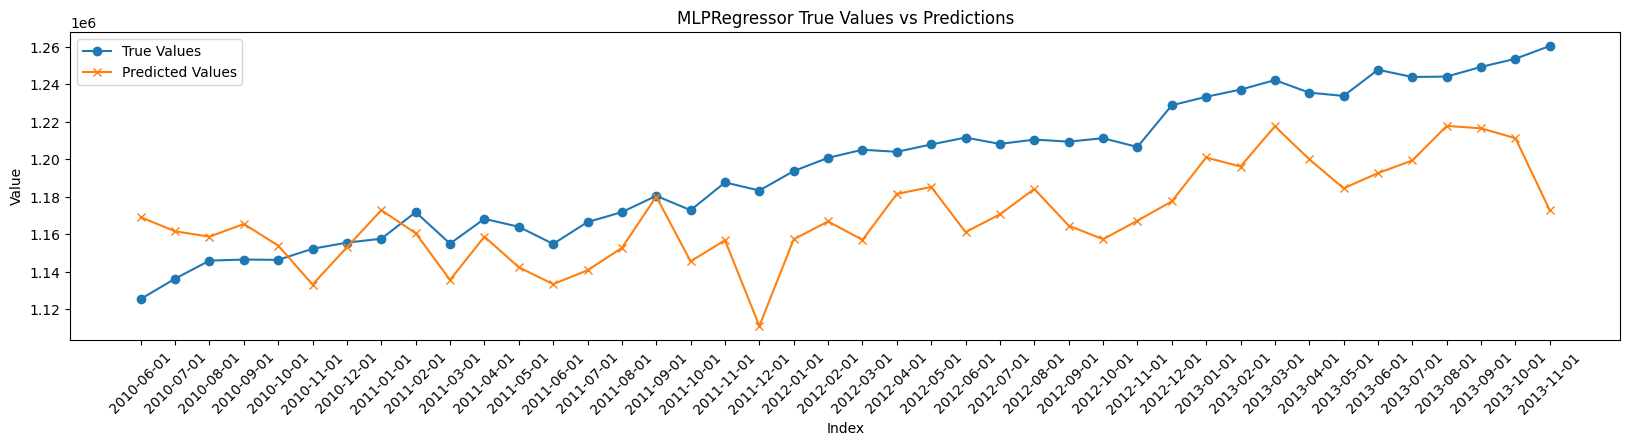

In [288]:
window_size = 43  # Size of the sliding window
step_size = 1  

n_samples = len(X)

for model in models:
    model_name = model.__class__.__name__
    model_predictions = []
    true_values = []

    for i in range(0, n_samples - window_size - 1, step_size):
        X_train = X[0:i+window_size]
        y_train = y[0:i+window_size]
        
        # Predicting one month after
        X_test = X[i+window_size:i+window_size+1]
        y_test = y[i+window_size]

        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        predicted_value = prediction[-1]
        model_predictions.append(predicted_value)
        true_values.append(y_test)

    # Plotting true values and predicted values for the current model
    plt.figure(figsize=(20, 4))
    plt.plot(MI_df['observation_date'][window_size+1:],true_values, label='True Values', marker='o')
    plt.plot(MI_df['observation_date'][window_size+1:],model_predictions, label='Predicted Values', marker='x')
    plt.xticks(rotation=45)
    plt.title(f'{model_name} True Values vs Predictions')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()